# Final Project - DEEP Reinforcements Learning


### Name and ID:
Student 1: Lior Baruch
<br>
Student 2:
<br>

# Pre-Requisit

## Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install gym-minigrid
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install -U --no-cache-dir gdown --pre

## Imports

In [ ]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import random
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

Device: cuda


## Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Class Env

In [ ]:
from __future__ import annotations
from gym_minigrid.minigrid import COLOR_NAMES
from gym_minigrid.minigrid import Grid
from gym_minigrid.minigrid import MissionSpace
from gym_minigrid.minigrid import Door, Goal, Key, Wall, Lava, Floor
from minigrid_x import MiniGridEnv
from gym import spaces
import random

class RandomEmptyEnv_10(MiniGridEnv):
    def __init__(
        self,
        size=10, # DEFINE THE WIDTH AND HEIGHT
        agent_start_pos=(1, 1),
        agent_start_dir = 0,
        max_steps: int | None = None,
        **kwargs,
    ):

        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        agent_start_x_loc =random.randint(1, 6)
        agent_start_y_loc =random.randint(1, 6)

        self.agent_start_pos = (agent_start_x_loc,agent_start_y_loc)

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )
        self.action_space = spaces.Discrete(3)
        self.walls_init = []

        # change 21-09 for random env
        self.not_goal_loc = [(col,row) for col in range(self.unwrapped.width) for row in range(self.unwrapped.height) if row == 0 or row == (self.unwrapped.width-1) or col == 0 or col == (self.unwrapped.height-1)]
        self.not_goal_loc.append(self.agent_start_pos)
        self.goal_pos = (self.grid.width - 2, self.grid.height - 2)

    def reset(self, **kwargs):
        # Randomize start position each time environment is reset
        agent_start_x_loc = random.randint(1, 6)
        agent_start_y_loc = random.randint(1, 6)
        self.agent_start_pos = (agent_start_x_loc, agent_start_y_loc)

        self.values = [0, 1, 2, 3]
        self.agent_start_dir = random.choice(self.values)

        # Recalculate not_goal_loc as it depends on the agent's start position
        self.not_goal_loc = [(col, row) for col in range(self.unwrapped.width) for row in range(self.unwrapped.height)
                             if row == 0 or row == (self.unwrapped.width - 1) or col == 0 or col == (self.unwrapped.height - 1)]
        self.not_goal_loc.append(self.agent_start_pos)

        # Call the reset method of the parent class
        return super().reset(**kwargs)

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate verical separation wall
        # for i in range(0, height):
        #     self.grid.set(5, i, Wall())


        for column, row in self.walls_init:
          self.grid.set(column, row, Wall())

        self.key_pos = (6, 5)
        self.door_pos = (6, 7)

        self.goal_pos = random.choice([(8,1), (8,8), (1,8)])

        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"


In [ ]:
from __future__ import annotations
from gym_minigrid.minigrid import COLOR_NAMES
from gym_minigrid.minigrid import Grid
from gym_minigrid.minigrid import MissionSpace
from gym_minigrid.minigrid import Door, Goal, Key, Wall, Lava, Floor
from minigrid_x import MiniGridEnv
from gym import spaces
import random

class RandomKeyMEnv_10(MiniGridEnv):
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )
        self.partition_col = 3
        self.walls_init = [(self.partition_col, i) for i in range(0, self.grid.height)]
        self.goal_pos = (self.grid.width - 2, self.grid.height - 2)


    def get_pass_location(self):
      return (self.partition_col, self.pass_loc)

    def get_partition_column(self):
      return self.partition_col

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def get_k_pos(self):
      return self.key_pos

    def get_d_pos(self):
      return self.door_pos

    def _gen_grid(self, width, height):
        # Place Dor in random location within all column the partition
        self.pass_loc = random.choice([op_row for op_row in range(1, self.unwrapped.width-1)])

        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate verical separation wall
        # for i in range(0, height):
        #     self.grid.set(5, i, Wall())


        for column, row in self.walls_init:
          self.grid.set(column, row, Wall())

        # Place Key in random location within all the free spaces left to the partition
        self.key_pos = (random.choice([k_col for k_col in range(1,self.partition_col)]), random.choice([k_row for k_row in range(2,self.unwrapped.height-1)]))
        self.door_pos = (self.partition_col, self.pass_loc)

        self.env_door = Door(COLOR_NAMES[0], is_locked=True)

        # Place the Lava
        # self.grid.set(4, 6, Lava())

        # Place the door and key
        self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)
        self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))
        self.goal_pos = (width - 2, height - 2)
        # Place a goal square in the bottom-right corner
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"

    def is_carrying_key(self):
        if 'Key' in str(self.unwrapped.carrying):
            return True
        return False

    def is_door_open(self):
        return self.unwrapped.env_door.is_open

## WRAPPER

In [ ]:
class EMPTYRGBImgObsWrapper(gym.core.ObservationWrapper):
    """
    Wrapper to use fully observable RGB image as the only observation output,
    no language/mission. This can be used to have the agent to solve the
    gridworld in pixel space.
    """

    def __init__(self, env, tile_size=32, plot=False, preprocess= lambda x: x):
        super().__init__(env)
        self.tile_size = tile_size
        self.plot = plot
        # self.observation_space = spaces.Box(
        #     low=0,
        #     high=255,
        #     # #the default is (320,320,3). Tile size  = 32 X 10 (grid size)
        #     # TODO: BE CAREFULL TO CHANGE the shape size to be according your preprocess size/channels
        #     # The env information is taken from here
        #     shape=(320, 320, 3),
        #     dtype='uint8'
        # )
        self.observation_space = spaces.Box(
            low=0,
            high=1,  # Normalized pixel values
            shape=(64, 64, 1),  # Updated shape to match preprocess output
            dtype='float32'
        )
        self.prev_door = False
        self.prev_key = False
        self.action_space = spaces.Discrete(self.action_space.n)

        #TODO: THINK AND TEST DIFFERENT PREPROCESS
        self._preprocess = preprocess


    def observation(self, obs):
      env = self.unwrapped

      # Call render without any unsupported keyword arguments
      rgb_img = env.render()  # Use the default rendering behavior
      return rgb_img

    def reset(self, seed = 0, options = None):
        self.prev_door = False
        self.prev_key = False
        obs, info = super().reset()
        if self.plot:
            plt.show()
        return self._preprocess(obs), info

    def step(self, action):
        #action = ACTION_MAP[action]
        obs, r, d, info, x = super().step(action)
        obs = self._preprocess(obs)

        # TODO: REWARD SHAPING
        r *= 100 # if done r=100 else r=0
        r -= 1 # punishment for each step

        return obs, r, d, info, x



In [ ]:

ACTION_MAP = {0:0,
              1:1,
              2:2,
              3:3,
              4:5,
              5:5}


class KEYRGBImgObsWrapper(gym.core.ObservationWrapper):
    """
    Wrapper to use fully observable RGB image as the only observation output,
    no language/mission. This can be used to have the agent to solve the
    gridworld in pixel space.
    """

    def __init__(self, env, tile_size=32, plot=False, preprocess= lambda x: x):
        super().__init__(env)

        self.tile_size = tile_size
        self.plot = plot
        # self.observation_space = spaces.Box(
        #     low=0,
        #     high=255,
        #     # #the default is (320,320,3). Tile size  = 32 X 10 (grid size)
        #     # TODO: BE CAREFULL TO CHANGE the shape size to be according your preprocess size/channels
        #     # The env information i staken from here
        #     shape=(320, 320, 3),
        #     dtype='uint8'
        # )
        self.observation_space = spaces.Box(
            low=0,
            high=1,  # Normalized pixel values
            shape=(64, 64, 1),  # Updated shape to match preprocess output
            dtype='float32'
        )
        self.prev_door = False
        self.prev_key = False
        self.action_space = spaces.Discrete(self.action_space.n - 2)

        #TODO: THINK AND TEST DIFFERENT PREPROCESS
        self._preprocess = preprocess


    def observation(self, obs):
      env = self.unwrapped

      # Call render without any unsupported keyword arguments
      rgb_img = env.render()  # Use the default rendering behavior
      return rgb_img

    def reset(self, seed = 0, options = None):
        self.prev_door = False
        self.prev_key = False
        obs, info = super().reset()
        if self.plot:
            plt.show()
        return self._preprocess(obs), info

    def step(self, action):
        action = ACTION_MAP[action]
        obs, r, d, info, x = super().step(action)
        obs = self._preprocess(obs)

        # TODO: REWARD SHAPING
        r *= 100 # if done reward is 10 else 0
        r -= 0.1 # penalize the agent for each step
        # if the agent drops the key or closes the door, we penalize it
        if (self.prev_key and not self.is_carrying_key()) or (self.prev_door and not self.is_door_open()):
            r -= 10
        # if the agent picks up the key or opens the door, we reward it
        if (not self.prev_key and self.is_carrying_key()) or (not self.prev_door and self.is_door_open()):
            r += 10

        # Update the previous key and door status
        self.prev_key = self.is_carrying_key()
        self.prev_door = self.is_door_open()

        return obs, r, d, info, x



## Preprocessing Method

In [ ]:
def pre_process(obs, crop_edges=35, resize_shape=(64, 64)):
    # Crop the edges of the image
    obs = obs[crop_edges:-crop_edges, crop_edges:-crop_edges]
    # Convert the image to grayscale
    obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    # Normalize the image
    obs = obs / 255.0
    # remove grid lines by resizing the image to 125x125 with interpolation=cv2.INTER_NEAREST
    obs = cv2.resize(obs, (125, 125), interpolation=cv2.INTER_NEAREST)
    # Scale down the image to resize_shape
    obs = cv2.resize(obs, resize_shape, interpolation=cv2.INTER_NEAREST)
    # Add a channel dimension
    obs = obs.reshape(resize_shape[0], resize_shape[1], 1)
    return obs

## Empty Env Info

(64, 64, 1)
(320, 320, 3)
original screen


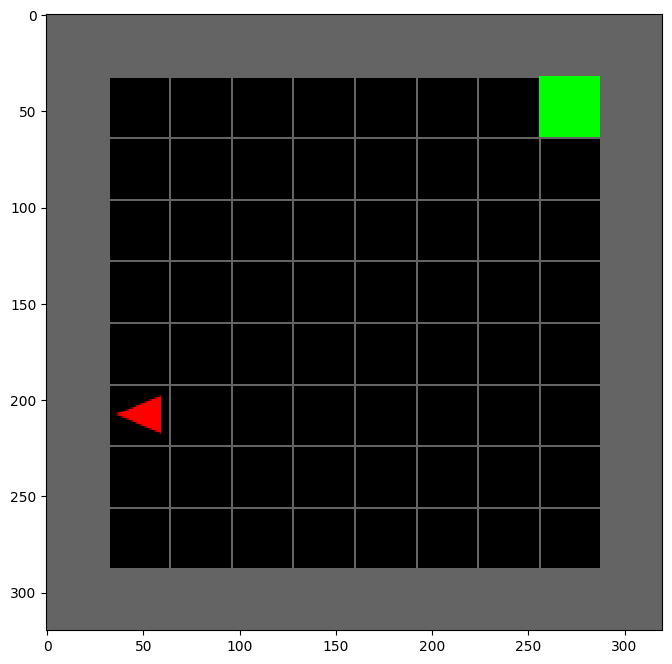

preprocess obs


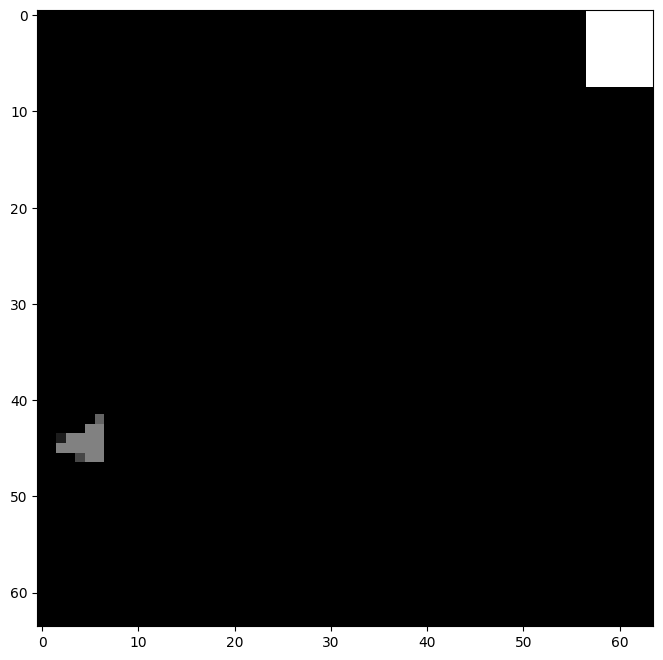

In [ ]:
env = EMPTYRGBImgObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array'), preprocess=pre_process)
obs = env.reset()[0] # 64x64x1
print(obs.shape)
screen = env.render() # 320x320x3
print(screen.shape)
print("original screen")
plt.imshow(screen)
plt.show()
print("preprocess obs")
plt.imshow(obs, cmap='gray')
plt.show()

In [ ]:
state_size = obs.shape  # Replace with your actual state size
action_space = env.action_space
num_actions = action_space.n
print(f"Number of actions: {num_actions}") # 3
print(f"State size is: {state_size}") # (64, 64, 1)

Number of actions: 3
State size is: (64, 64, 1)


## Key Env Info

(64, 64, 1)
(320, 320, 3)


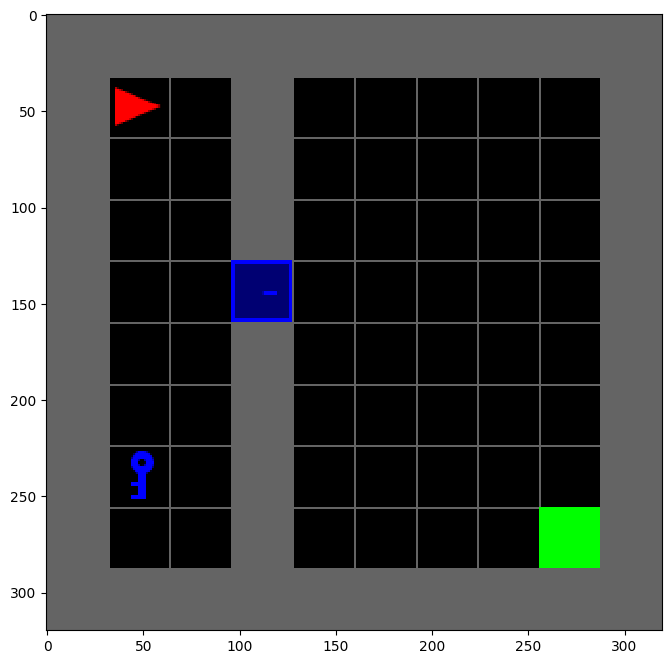

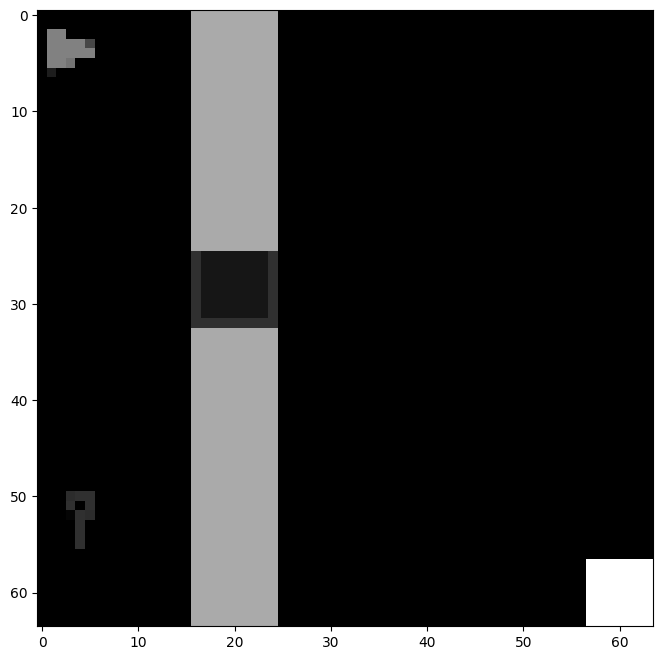

In [ ]:
env = KEYRGBImgObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'), preprocess=pre_process)
obs = env.reset()[0] # 64x64x1
print(obs.shape)
screen = env.render() # 320x320x3
print(screen.shape)
plt.imshow(screen)
plt.show()
plt.imshow(obs, cmap='gray')
plt.show()

In [ ]:
state_size = obs.shape  # Replace with your actual state size
action_space = env.action_space
num_actions = action_space.n
print(f"Number of actions: {num_actions}")
print(f"State size is: {state_size}")

Number of actions: 5
State size is: (64, 64, 1)


## Random action

In [ ]:
# env = EMPTYRGBImgObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array'))
# obs = env.reset()
# video_filename = '/content/vid.mp4'
# max_steps = 100
# # Evaluation
# with imageio.get_writer(video_filename, fps=10) as video:
#   obs = env.reset()
#   done = False
#   total_reward = 0
#   for step in range(max_steps):
#       action = env.action_space.sample()
#       obs, reward, done, _, _ = env.step(action)
#       next_obs = obs  # Get agent's position directly from the environment
#       video.append_data(env.render())
#       if done:
#         print("done","reward=", total_reward,"num_of_steps=",step)
#         break
# embed_mp4(video_filename)



In [ ]:
# env = KEYRGBImgObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
# obs = env.reset()
# video_filename = '/content/vid.mp4'
# max_steps = 100
# # Evaluation
# with imageio.get_writer(video_filename, fps=10) as video:
#   obs = env.reset()
#   done = False
#   total_reward = 0
#   for step in range(max_steps):
#       action = env.action_space.sample()
#       obs, reward, done, _, _ = env.step(action)
#       next_obs = obs  # Get agent's position directly from the environment
#       video.append_data(env.render())
#       if done:
#         print("done","reward=", total_reward,"num_of_steps=",step)
#         break
# embed_mp4(video_filename)

# Post-Requisit

## Initialise the Device and Seed

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import random
from torch.distributions import Categorical
from tqdm import tqdm

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPU if it's available
print(f"Device: {device}")

# SEED for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Initialize the environment
env = EMPTYRGBImgObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array'), preprocess=pre_process)
obs = env.reset()[0] # 64x64x1
state_size = obs.shape  # 64x64x1
action_space = env.action_space # Discrete(3)
num_actions = action_space.n # 3

Device: cuda


## Helper functions for Plotting

In [ ]:
def plot_training_performance(scores, steps, dones, avg_every=10, algo_name="DQN", figsize=(10, 15)):
    """
    Plots the training performance for scores, steps, and dones, both averaged and non-averaged.

    Parameters:
    - scores: Array of score values.
    - steps: Array of step values.
    - dones: Array of done flags.
    - avg_every: Interval for averaging.
    """
    # Calculate averaged values
    avg_scores = [np.mean(scores[i:i+avg_every]) for i in range(0, len(scores), avg_every)]
    avg_steps = [np.mean(steps[i:i+avg_every]) for i in range(0, len(steps), avg_every)]
    avg_dones = [np.mean(dones[i:i+avg_every]) for i in range(0, len(dones), avg_every)]

    # Setup for plotting
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    x_values_avg = np.arange(0, len(scores), avg_every)
    x_values_full = np.arange(len(scores))

    # Plot training scores - both averaged and not averaged
    ax[0].plot(x_values_full, scores, color='lightgrey', label="Scores (Not Averaged)")
    ax[0].plot(x_values_avg, avg_scores, label=f"Scores (Averaged every {avg_every} episodes)", color='blue')
    ax[0].set_title(f"Training Scores - {algo_name}")
    ax[0].set_xlabel("Episode")
    ax[0].set_ylabel("Score")
    ax[0].legend()

    # Plot training steps - both averaged and not averaged
    ax[1].plot(x_values_full, steps, color='lightgrey', label="Steps (Not Averaged)")
    ax[1].plot(x_values_avg, avg_steps, label=f"Steps (Averaged every {avg_every} episodes)", color='blue')
    ax[1].set_title(f"Training Steps - {algo_name}")
    ax[1].set_xlabel("Episode")
    ax[1].set_ylabel("Steps")
    ax[1].legend()

    # Plot training dones - both averaged and not averaged
    ax[2].plot(x_values_full, dones, color='lightgrey', label="Dones (Not Averaged)")
    ax[2].plot(x_values_avg, avg_dones, label=f"Dones (Averaged every {avg_every} episodes)", color='blue')
    ax[2].set_title(f"Training Dones - {algo_name}")
    ax[2].set_xlabel("Episode")
    ax[2].set_ylabel("Dones")
    ax[2].legend()

    plt.tight_layout()
    plt.show()

# method to plot like above but with multiple agents on the same plot
def plot_training_performance_multi(scores_list, steps_list, dones_list, labels, avg_every=10, algo_name="DQN", figsize=(10, 15)):
    """
    Plots the training performance for scores, steps, and dones, both averaged and non-averaged.

    Parameters:
    - scores_list: List of arrays of score values.
    - steps_list: List of arrays of step values.
    - dones_list: List of arrays of done flags.
    - labels: List of labels for the agents.
    - avg_every: Interval for averaging.
    """
    # Setup for plotting
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    x_values_avg = np.arange(0, len(scores_list[0]), avg_every)
    x_values_full = np.arange(len(scores_list[0]))

    # Plot training scores - both averaged and not averaged
    for i, scores in enumerate(scores_list):
        avg_scores = [np.mean(scores[i:i+avg_every]) for i in range(0, len(scores), avg_every)]
        ax[0].plot(x_values_avg, avg_scores, label=f"Scores - {labels[i]} (Averaged every {avg_every} episodes)")
    ax[0].set_title(f"Training Scores - {algo_name}")
    ax[0].set_xlabel("Episode")
    ax[0].set_ylabel("Score")
    ax[0].legend()

    # Plot training steps - both averaged and not averaged
    for i, steps in enumerate(steps_list):
        avg_steps = [np.mean(steps[i:i+avg_every]) for i in range(0, len(steps), avg_every)]
        ax[1].plot(x_values_avg, avg_steps, label=f"Steps - {labels[i]} (Averaged every {avg_every} episodes)")
    ax[1].set_title(f"Training Steps - {algo_name}")
    ax[1].set_xlabel("Episode")
    ax[1].set_ylabel("Steps")
    ax[1].legend()

    # Plot training dones - both averaged and not averaged
    for i, dones in enumerate(dones_list):
        avg_dones = [np.mean(dones[i:i+avg_every]) for i in range(0, len(dones), avg_every)]
        ax[2].plot(x_values_avg, avg_dones, label=f"Dones - {labels[i]} (Averaged every {avg_every} episodes)")
    ax[2].set_title(f"Training Dones - {algo_name}")
    ax[2].set_xlabel("Episode")
    ax[2].set_ylabel("Dones")
    ax[2].legend()

    plt.tight_layout()
    plt.show()

def plot_evaluation_performance_multi(scores_list, steps_list, dones_list, labels, figsize=(10, 15)):
    """
    Plots the evaluation performance for scores, steps, and dones for multiple agents.

    Parameters:
    - scores_list: List of scores for each agent.
    - steps_list: List of steps for each agent.
    - dones_list: List of dones for each agent.
    - labels: List of labels for the agents.
    """
    x = np.arange(len(labels))
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    ax[0].bar(x, scores_list, color='lightblue')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(labels)
    ax[0].set_title("Average Scores")
    ax[0].set_ylabel("Score")
    ax[1].bar(x, steps_list, color='lightgreen')
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(labels)
    ax[1].set_title("Average Steps")
    ax[1].set_ylabel("Steps")
    ax[2].bar(x, dones_list, color='lightcoral')
    ax[2].set_xticks(x)
    ax[2].set_xticklabels(labels)
    ax[2].set_title("Average Dones")
    ax[2].set_ylabel("Dones")
    plt.tight_layout()
    plt.show()

def save_video(agent, env, filename, max_steps=100):
    """ Save a video of the agent's performance """
    with imageio.get_writer(filename, fps=10) as video:
        obs = env.reset()[0]
        done = False
        total_reward = 0
        for step in range(max_steps):
            action = agent.act(obs, eps=0) # No exploration
            obs, reward, done, _, _ = env.step(action)
            video.append_data(env.render())
            total_reward += reward
            if done:
                break
    return total_reward, step+1, done

## ReplayBuffer

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch)) # Stack the batch into a single numpy array
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)


In [ ]:
def pre_process_batch(experiences):
    """ Convert batch of experiences to tensors """
    states, actions, rewards, next_states, dones = (experiences)
    states = torch.tensor(states, dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.int32).to(device)
    actions = actions.unsqueeze(-1)
    rewards = rewards.unsqueeze(-1)
    dones = dones.unsqueeze(-1)
    return states, actions, rewards, next_states, dones


## QNetwork

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(64*4*4, 512)
        self.fc2 = nn.Linear(512, action_size)

    def forward(self, state):
        #print("before",state.shape)
        x = state.reshape(-1, 1, 64, 64) # (B, H, W, C) -> (B, C, H, W)
        #print("after",x.shape)
        x = F.relu(self.conv1(x)) # (B, 1, 64, 64) -> (B, 32, 14, 14)
        #print("after conv1",x.shape)
        x = F.relu(self.conv2(x)) # (B, 32, 14, 14) -> (B, 64, 6, 6)
        #print("after conv2",x.shape)
        x = F.relu(self.conv3(x)) # (B, 64, 6, 6) -> (B, 64, 4, 4)
        #print("after conv3",x.shape)
        x = x.view(-1, 64*4*4) # (B, 64, 4, 4) -> (B, 64*4*4)
        #print("after view",x.shape)
        x = F.relu(self.fc1(x)) # (B, 64*4*4) -> (B, 512)
        #print("after fc1",x.shape)
        x = self.fc2(x) # (B, 512) -> (B, action_size)
        return x



## Dueling QNetwork


In [ ]:
class DuelingQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DuelingQNetwork, self).__init__()
        # Existing layers remain the same
        self.conv1 = nn.Conv2d(1, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        self.fc1_adv = nn.Linear(64*4*4, 512)
        self.fc1_val = nn.Linear(64*4*4, 512)

        # Advantage and value streams
        self.fc2_adv = nn.Linear(512, action_size)
        self.fc2_val = nn.Linear(512, 1)  # Single value output

    def forward(self, state):
        x = state.reshape(-1, 1, 64, 64) # Adjust based on your state shape
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64*4*4)

        adv = F.relu(self.fc1_adv(x))
        val = F.relu(self.fc1_val(x))

        adv = self.fc2_adv(adv)
        val = self.fc2_val(val)

        # Combine the value and advantage streams
        q_values = val + (adv - adv.mean(dim=1, keepdim=True))
        return q_values


## DQNAgent (includig DQN, Double DQN, Dueling DQN, Dueling Double DQN)

In [ ]:
class DQNAgent:

    def __init__(self, state_size, action_size, buffer_size, batch_size, gamma, tau, lr, update_every, double_dqn=False, duel_dqn=False):
        self.state_size = state_size
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.update_every = update_every
        self.double_dqn = double_dqn
        self.duel_dqn = duel_dqn
        self.t_step = 0

        # Q-Network
        if duel_dqn: # Use Dueling DQN
            self.q_network_local = DuelingQNetwork(state_size, action_size).to(device)
            self.q_network_target = DuelingQNetwork(state_size, action_size).to(device)
        else: # Use regular DQN
            self.q_network_local = QNetwork(state_size, action_size).to(device)
            self.q_network_target = QNetwork(state_size, action_size).to(device)
        # Optimizer
        self.optimizer = optim.Adam(self.q_network_local.parameters(), lr=lr)

        # Replay memory
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        """ Save experience in replay memory, and use random sample from buffer to learn """
        self.memory.push(state, action, reward, next_state, done) # Save experience
        self.t_step = (self.t_step + 1) % self.update_every # Learn every update_every time steps
        if self.t_step == 0:
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample(self.batch_size) # Get random batch of experiences
                self.learn(experiences) # Learn from experiences

    def act(self, state, eps=0.):
        """ Returns actions for given state as per current policy """
        if random.random() > eps:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            self.q_network_local.eval()
            with torch.no_grad():
                action_values = self.q_network_local(state)
            self.q_network_local.train()
            return np.argmax(action_values.cpu().data.numpy())
        else: # select random action
            return random.choice(np.arange(self.action_size))

    def learn_DQN(self, experiences):
        """
        DQN learning algorithm
        In DQN, the max predicted Q values (for next states) are used for updating the local network.
        """
        states, actions, rewards, next_states, dones = pre_process_batch(experiences)
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.q_network_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        # Get expected Q values from local model
        Q_expected = self.q_network_local(states).gather(1, actions)
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # Update target network
        self.soft_update(self.q_network_local, self.q_network_target, self.tau)

    def learn_Double_DQN(self, experiences):
        """ Double DQN learning algorithm
        In Double DQN, the best action is selected using the local network, but the Q value is evaluated using the target network.
        """
        states, actions, rewards, next_states, dones = pre_process_batch(experiences)

        # Determine the best action for each next state using the local network.
        local_q_values_next = self.q_network_local(next_states).detach()
        max_action_indices = local_q_values_next.max(1)[1].unsqueeze(1)

        # Evaluate these selected actions using the target network.
        #q_values_next_target = self.q_network_target(next_states).detach().gather(1, max_action_indices)
        q_values_next_target = self.q_network_target(next_states).gather(1, max_action_indices)

        # Calculate the Q targets for current states.
        q_targets_current = rewards + (self.gamma * q_values_next_target * (1 - dones))

        # Obtain the expected Q values from the local model for the current state-action pairs.
        q_expected_current = self.q_network_local(states).gather(1, actions)

        # Compute the loss between expected Q values and the target Q values.
        loss = F.mse_loss(q_expected_current, q_targets_current)

        # Backpropagate the loss to update the network weights.
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Periodically update the target network with the local network weights.
        self.soft_update(self.q_network_local, self.q_network_target, self.tau)

    def learn(self, experiences):
        if self.double_dqn:
            self.learn_Double_DQN(experiences)
        else:
            self.learn_DQN(experiences)

    def soft_update(self, local_model, target_model, tau):
        """ Soft update model parameters, i.e target_model = tau*local_model + (1-tau)*target_model """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def train(self, env, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, print_every=100):
        """ Deep Q-Learning """
        scores = [] # list containing scores from each episode
        steps = [] # list containing the number of steps from each episode
        dones = [] # list containing the done flag from each episode
        eps = eps_start
        for i_episode in tqdm(range(1, n_episodes+1)):
            state = env.reset()[0]
            score = 0
            for t in range(max_t):
                action = self.act(state, eps)
                next_state, reward, done, _, _ = env.step(action)
                self.step(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break
            scores.append(score)
            steps.append(t)
            dones.append(done)
            eps = max(eps_end, eps_decay*eps)
            if i_episode % print_every == 0:
                print(f"Episode {i_episode}/{n_episodes} -- Average Score: {np.mean(scores[-print_every:]):.2f} -- Average Steps: {np.mean(steps[-print_every:]):.2f} -- Average Dones: {np.mean(dones[-print_every:]):.2f} -- Epsilon: {eps:.2f}")
        return scores, steps, dones

    def evaluate(self, env, n_episodes=3, max_t=1000):
        """ Evaluate agent's performance """
        scores = []
        steps = []
        dones = []
        for i_episode in tqdm(range(1, n_episodes+1)):
            state = env.reset()[0]
            score = 0
            for t in range(max_t):
                action = self.act(state, eps=0) # No exploration
                next_state, reward, done, _, _ = env.step(action)
                state = next_state
                score += reward
                if done:
                    break
            scores.append(score)
            steps.append(t)
            dones.append(done)

        avg_score = np.mean(scores)
        avg_steps = np.mean(steps)
        avg_dones = np.mean(dones)
        return avg_score, avg_steps, avg_dones

    def save(self, filename):
        """ Save the model """
        torch.save(self.q_network_local.state_dict(), filename)

    def load(self, filename):
        """ Load the model """
        self.q_network_local.load_state_dict(torch.load(filename))
        self.q_network_target.load_state_dict(torch.load(filename))
        self.q_network_local.eval()
        self.q_network_target.eval()


## Training the Agent on the Empty Env

In [ ]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPU if it's available
print(f"Device: {device}")

# SEED for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Initialize the environment
env = EMPTYRGBImgObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array'), preprocess=pre_process)
obs = env.reset()[0] # 64x64x1
state_size = obs.shape  # 64x64x1
action_space = env.action_space # Discrete(3)
num_actions = action_space.n # 3

Device: cuda


### DQN
- Hyperparameters
- Initialise the Agent
- Training the Agent and saving the model and training logs
- Load the model and plot the training logs
- Evaluate the Agent
- Watch the Agent play

- Hyperparameters

In [ ]:
# Agent Hyperparameters
buffer_size = int(1e4)
batch_size = 64
gamma = 0.99 # discount factor
tau = 1e-2 # soft update of target parameters
lr = 1e-3
update_every = 4

# Set the hyperparameters string
hyperparameters_str = f"buffer_size={buffer_size}_batch_size={batch_size}_gamma={gamma}_tau={tau}_lr={lr}_update_every={update_every}"
path_for_agent = f"models_simple_DQN_{hyperparameters_str}.pth"
path_for_scores_steps = f"scores_steps_simple_DQN_scores_steps_{hyperparameters_str}.csv"

- Initialise the Agent

In [ ]:
# Initialize the agent
DQN_agent = DQNAgent(
    state_size=state_size,
    action_size=num_actions,
    buffer_size=buffer_size,
    batch_size=batch_size,
    gamma=gamma,
    tau=tau,
    lr=lr,
    update_every=update_every,
    double_dqn=False,
    duel_dqn=False
)

- Training the Agent and saving the model and training logs

In [ ]:
# Train the agent
print("Training the DQN agent")
dqn_scores, dqn_steps, dqn_dones = DQN_agent.train(
    env=env,
    n_episodes=1000,
    max_t=250,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay=0.995,
    print_every=100
)
print("Finished training the DQN agent")


# Save the agent
DQN_agent.save(path_for_agent)
print(f"DQN agent saved as DQN_{hyperparameters_str}.pth")

# Save the scores steps and dones
scores_steps_dones = pd.DataFrame({'scores': dqn_scores, 'steps': dqn_steps, 'dones': dqn_dones})
scores_steps_dones.to_csv(path_for_scores_steps, index=False)
print(f"DQN scores, steps, and dones saved as DQN_scores_steps_{hyperparameters_str}.csv")

Training the DQN agent


 10%|█         | 100/1000 [01:22<09:17,  1.61it/s]

Episode 100/1000 -- Average Score: -120.50 -- Average Steps: 170.50 -- Average Dones: 0.51 -- Epsilon: 0.61


 20%|██        | 200/1000 [02:26<04:12,  3.17it/s]

Episode 200/1000 -- Average Score: -76.34 -- Average Steps: 134.34 -- Average Dones: 0.59 -- Epsilon: 0.37


 30%|███       | 301/1000 [02:49<01:06, 10.59it/s]

Episode 300/1000 -- Average Score: 45.48 -- Average Steps: 46.52 -- Average Dones: 0.93 -- Epsilon: 0.22


 40%|████      | 402/1000 [02:58<00:42, 14.17it/s]

Episode 400/1000 -- Average Score: 82.41 -- Average Steps: 16.59 -- Average Dones: 1.00 -- Epsilon: 0.13


 50%|█████     | 503/1000 [03:06<00:29, 17.07it/s]

Episode 500/1000 -- Average Score: 86.30 -- Average Steps: 12.70 -- Average Dones: 1.00 -- Epsilon: 0.08


 60%|██████    | 603/1000 [03:14<00:54,  7.24it/s]

Episode 600/1000 -- Average Score: 82.33 -- Average Steps: 14.67 -- Average Dones: 0.98 -- Epsilon: 0.05


 70%|███████   | 702/1000 [03:20<00:16, 17.70it/s]

Episode 700/1000 -- Average Score: 89.13 -- Average Steps: 9.87 -- Average Dones: 1.00 -- Epsilon: 0.05


 80%|████████  | 802/1000 [03:25<00:11, 17.66it/s]

Episode 800/1000 -- Average Score: 89.46 -- Average Steps: 9.54 -- Average Dones: 1.00 -- Epsilon: 0.05


 90%|█████████ | 904/1000 [03:31<00:05, 19.00it/s]

Episode 900/1000 -- Average Score: 89.28 -- Average Steps: 9.72 -- Average Dones: 1.00 -- Epsilon: 0.05


100%|██████████| 1000/1000 [03:37<00:00,  4.61it/s]

Episode 1000/1000 -- Average Score: 89.94 -- Average Steps: 9.06 -- Average Dones: 1.00 -- Epsilon: 0.05
Finished training the DQN agent
DQN agent saved as DQN_buffer_size=10000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.pth
DQN scores, steps, and dones saved as DQN_scores_steps_buffer_size=10000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.csv


- Load the model and the training log
- Plot the training logs

Scores, steps, and dones loaded from DQN_scores_steps_buffer_size=10000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.csv


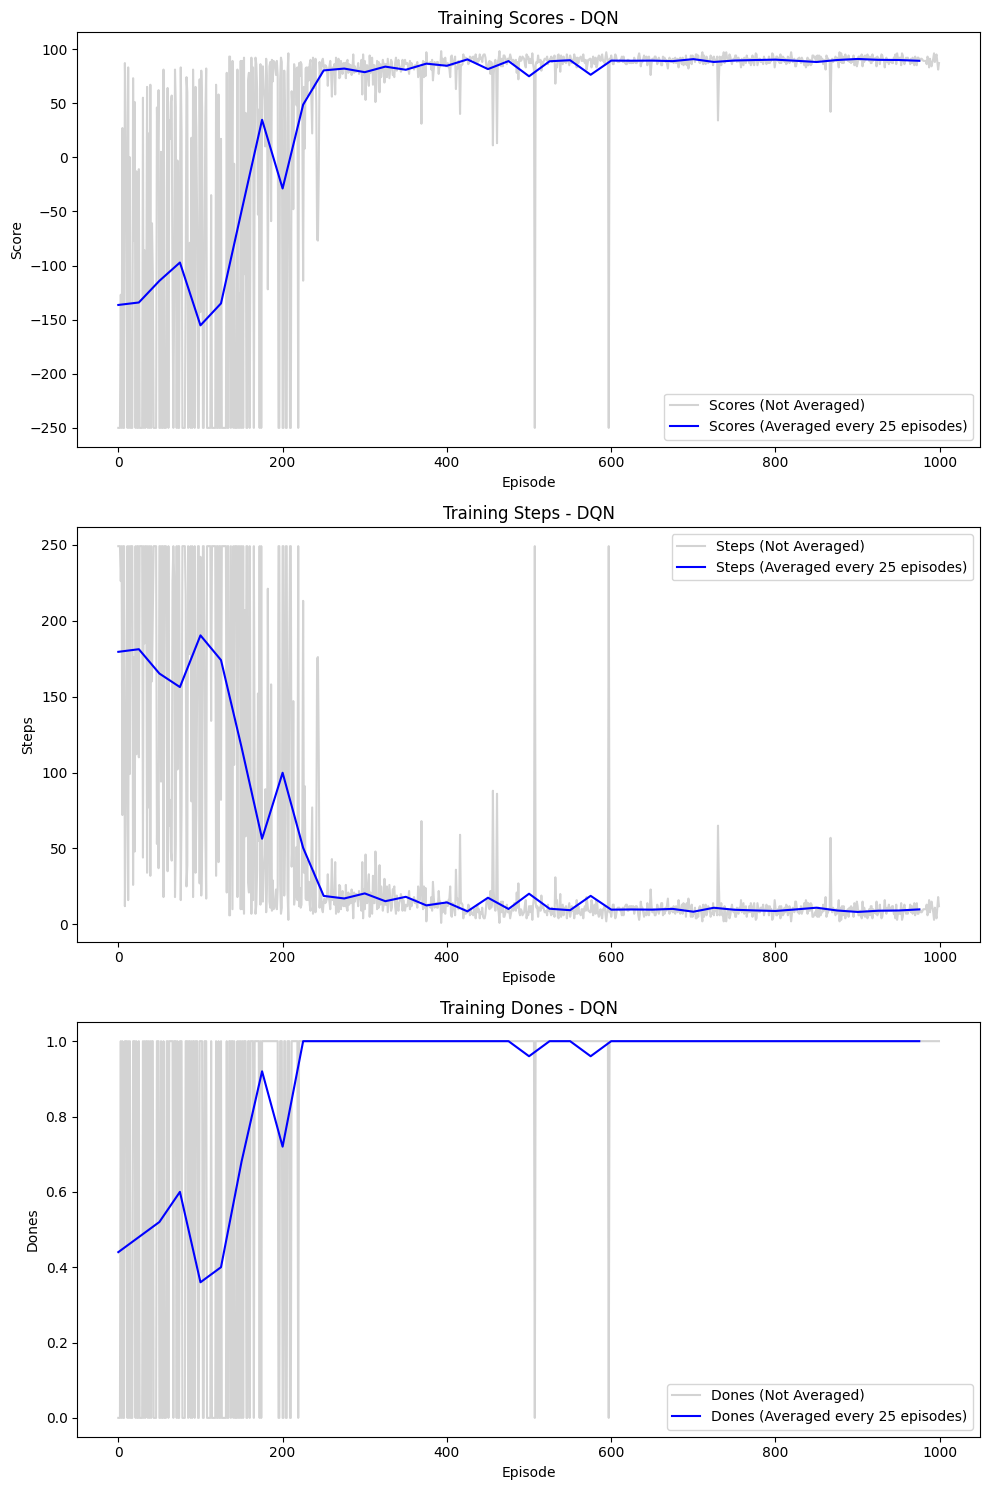

In [ ]:
# Load the model scores and steps
DQN_agent.load(path_for_agent)
scores_steps_dones = pd.read_csv(path_for_scores_steps)
print(f"Scores, steps, and dones loaded from DQN_scores_steps_{hyperparameters_str}.csv")

# Extract scores, steps, and dones
dqn_scores = scores_steps_dones["scores"].values
dqn_steps = scores_steps_dones["steps"].values
dqn_dones = scores_steps_dones["dones"].values

# Parameters for averaging
avg_every = 25

# Plot the training performance
plot_training_performance(dqn_scores, dqn_steps, dqn_dones, avg_every=avg_every, algo_name="DQN", figsize=(10, 15))




- Evaluate the Agent

In [ ]:
# Evaluate the agent
print("Evaluating the DQN agent")
dqn_scores_eval, dqn_steps_eval, dqn_dones_eval = DQN_agent.evaluate(env=env, n_episodes=50)
print(f"DQN agent's average score: {dqn_scores_eval:.2f} -- average steps: {dqn_steps_eval:.2f} -- average dones: {dqn_dones_eval:.2f}")


Evaluating the DQN agent


100%|██████████| 50/50 [00:01<00:00, 31.64it/s]

DQN agent's average score: 90.00 -- average steps: 9.00 -- average dones: 1.00


- Watch the Agent play

In [ ]:
video_filename = '/content/vid.mp4'
total_reward, step, done = save_video(DQN_agent, env, video_filename, max_steps=100)
print(f"Total reward: {total_reward} -- Steps: {step} -- Done: {done}")
embed_mp4(video_filename)

Total reward: 89 -- Steps: 11 -- Done: True


### Double DQN
- Hyperparameters
- Initialise the Agent
- Training the Agent and saving the model and training logs
- Load the model and plot the training logs
- Evaluate the Agent

- Hyperparameters

In [ ]:
# Agent Hyperparameters.
buffer_size = int(1e4)
batch_size = 64
gamma = 0.99 # discount factor
tau = 1e-2 # soft update of target parameters
lr = 1e-3
update_every = 4

# Set the hyperparameters string
hyperparameters_str = f"buffer_size={buffer_size}_batch_size={batch_size}_gamma={gamma}_tau={tau}_lr={lr}_update_every={update_every}"
path_for_agent = f"models_simple_DoubleDQN_{hyperparameters_str}.pth"
path_for_scores_steps = f"scores_steps_simple_DoubleDQN_scores_steps_{hyperparameters_str}.csv"



- Initialise the agent

In [ ]:
double_DQN_agent = DQNAgent(
    state_size=state_size,
    action_size=num_actions,
    buffer_size=buffer_size,
    batch_size=batch_size,
    gamma=gamma,
    tau=tau,
    lr=lr,
    update_every=update_every,
    double_dqn=True,
    duel_dqn=False
)

- Training the agent and saving the model and training logs

In [ ]:
# Train the agent
print("Training the Double DQN agent")
double_dqn_scores, double_dqn_steps, double_dqn_dones = double_DQN_agent.train(
    env=env,
    n_episodes=1000,
    max_t=250,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay=0.995,
    print_every=100
)
print("Finished training the Double DQN agent")

# Save the agent
double_DQN_agent.save(path_for_agent)
print(f"Double DQN agent saved as DoubleDQN_{hyperparameters_str}.pth")

# Save the scores steps and dones
scores_steps_dones = pd.DataFrame({'scores': double_dqn_scores, 'steps': double_dqn_steps, 'dones': double_dqn_dones})
scores_steps_dones.to_csv(path_for_scores_steps, index=False)
print(f"Double DQN scores, steps, and dones saved as DoubleDQN_scores_steps_{hyperparameters_str}.csv")

Training the Double DQN agent


 10%|█         | 100/1000 [01:20<11:15,  1.33it/s]

Episode 100/1000 -- Average Score: -107.57 -- Average Steps: 166.57 -- Average Dones: 0.60 -- Epsilon: 0.61


 20%|██        | 201/1000 [02:33<04:14,  3.14it/s]

Episode 200/1000 -- Average Score: -86.42 -- Average Steps: 144.42 -- Average Dones: 0.59 -- Epsilon: 0.37


 30%|███       | 302/1000 [02:58<01:15,  9.23it/s]

Episode 300/1000 -- Average Score: 47.78 -- Average Steps: 44.22 -- Average Dones: 0.93 -- Epsilon: 0.22


 40%|████      | 403/1000 [03:08<00:36, 16.50it/s]

Episode 400/1000 -- Average Score: 81.23 -- Average Steps: 17.77 -- Average Dones: 1.00 -- Epsilon: 0.13


 50%|█████     | 501/1000 [03:15<00:36, 13.78it/s]

Episode 500/1000 -- Average Score: 87.56 -- Average Steps: 11.44 -- Average Dones: 1.00 -- Epsilon: 0.08


 60%|██████    | 602/1000 [03:23<00:23, 16.86it/s]

Episode 600/1000 -- Average Score: 85.74 -- Average Steps: 13.26 -- Average Dones: 1.00 -- Epsilon: 0.05


 70%|███████   | 703/1000 [03:29<00:17, 17.02it/s]

Episode 700/1000 -- Average Score: 89.70 -- Average Steps: 9.30 -- Average Dones: 1.00 -- Epsilon: 0.05


 80%|████████  | 802/1000 [03:35<00:13, 14.28it/s]

Episode 800/1000 -- Average Score: 89.48 -- Average Steps: 9.52 -- Average Dones: 1.00 -- Epsilon: 0.05


 90%|█████████ | 902/1000 [03:41<00:05, 17.55it/s]

Episode 900/1000 -- Average Score: 89.39 -- Average Steps: 9.61 -- Average Dones: 1.00 -- Epsilon: 0.05


100%|██████████| 1000/1000 [03:48<00:00,  4.39it/s]

Episode 1000/1000 -- Average Score: 89.36 -- Average Steps: 9.64 -- Average Dones: 1.00 -- Epsilon: 0.05
Finished training the Double DQN agent
Double DQN agent saved as DoubleDQN_buffer_size=10000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.pth
Double DQN scores, steps, and dones saved as DoubleDQN_scores_steps_buffer_size=10000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.csv


- Load the model and the training log
- Plot the training logs

Scores, steps, and dones loaded from DoubleDQN_scores_steps_buffer_size=10000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.csv


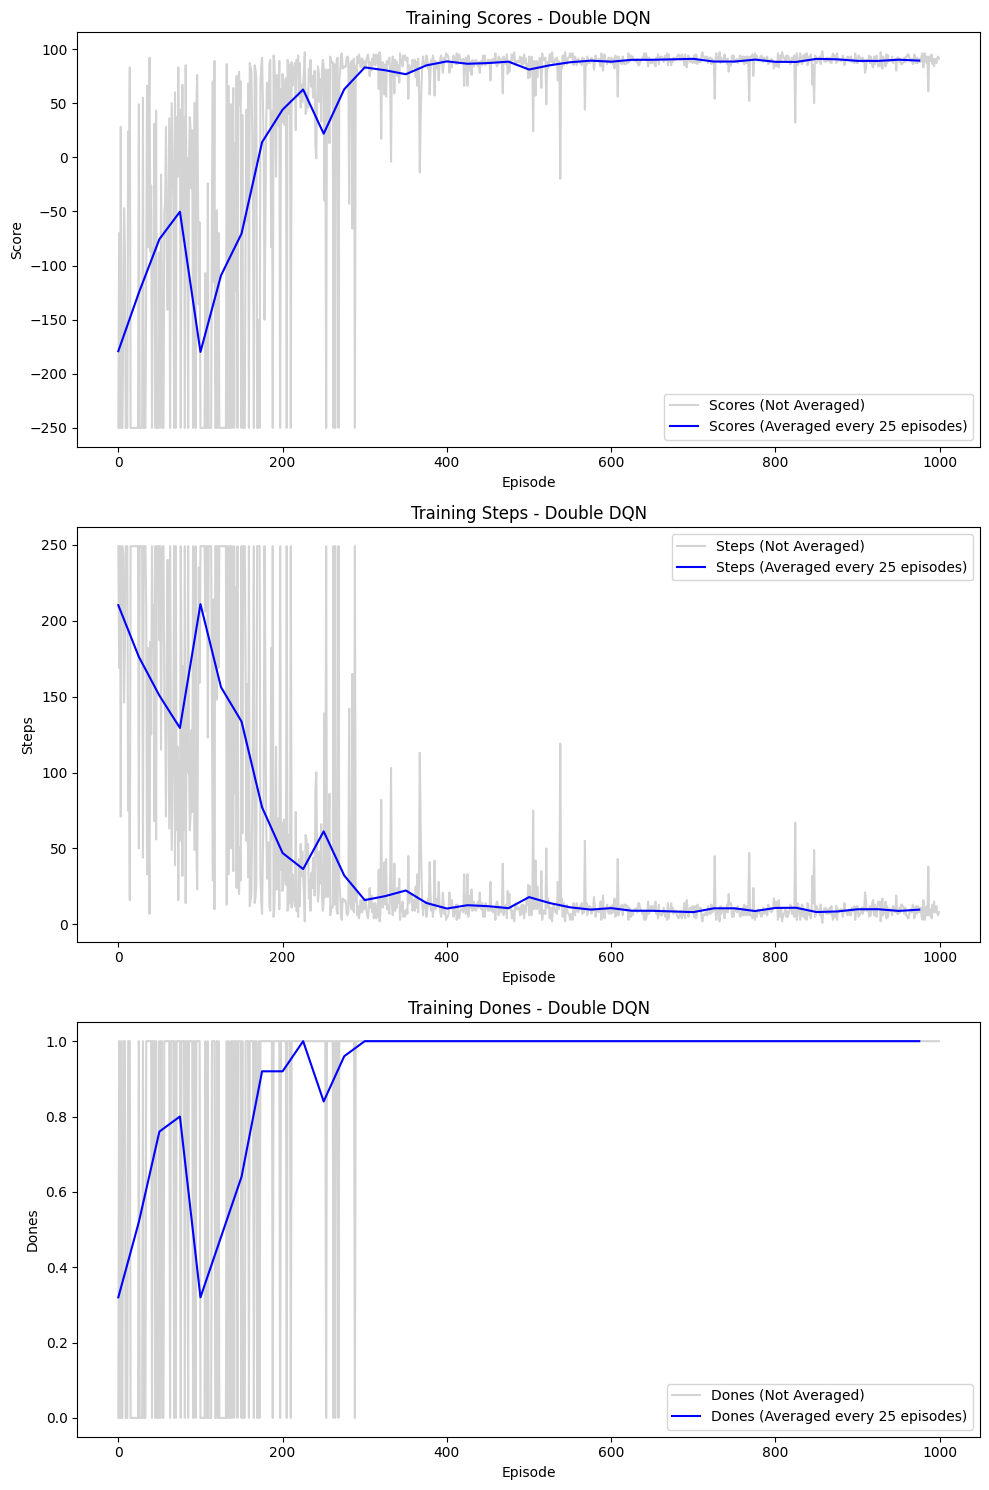

In [ ]:
# Load the model scores and steps
double_DQN_agent.load(path_for_agent)
scores_steps_dones = pd.read_csv(path_for_scores_steps)
print(f"Scores, steps, and dones loaded from DoubleDQN_scores_steps_{hyperparameters_str}.csv")

# Extract scores, steps, and dones
double_dqn_scores = scores_steps_dones["scores"].values
double_dqn_steps = scores_steps_dones["steps"].values
double_dqn_dones = scores_steps_dones["dones"].values

# Parameters for averaging
avg_every = 25

# Plot the training performance
plot_training_performance(double_dqn_scores, double_dqn_steps, double_dqn_dones, avg_every=avg_every, algo_name="Double DQN", figsize=(10, 15))



- Evaluate the agent

In [ ]:
# Evaluate the agent
print("Evaluating the Double DQN agent")
double_dqn_scores_eval, double_dqn_steps_eval, double_dqn_dones_eval = double_DQN_agent.evaluate(env=env, n_episodes=50)
print(f"Double DQN agent's average score: {double_dqn_scores_eval:.2f} -- average steps: {double_dqn_steps_eval:.2f} -- average dones: {double_dqn_dones_eval:.2f}")

Evaluating the Double DQN agent


100%|██████████| 50/50 [00:01<00:00, 33.87it/s]

Double DQN agent's average score: 90.44 -- average steps: 8.56 -- average dones: 1.00


- Watch the Agent play

In [ ]:
video_filename = '/content/vid.mp4'
total_reward, step, done = save_video(double_DQN_agent, env, video_filename, max_steps=100)
print(f"Total reward: {total_reward} -- Steps: {step} -- Done: {done}")
embed_mp4(video_filename)

Total reward: 90 -- Steps: 10 -- Done: True


### Dueling DQN
- Hyperparameters
- Initialise the Agent
- Training the Agent and saving the model and training logs
- Load the model and plot the training logs
- Evaluate the Agent
- Watch the Agent play

- Hyperparameters

In [ ]:
# Agent Hyperparameters.
buffer_size = int(1e4)
batch_size = 64
gamma = 0.99 # discount factor
tau = 1e-2 # soft update of target parameters
lr = 1e-3
update_every = 4

# Set the hyperparameters string
hyperparameters_str = f"buffer_size={buffer_size}_batch_size={batch_size}_gamma={gamma}_tau={tau}_lr={lr}_update_every={update_every}"
path_for_agent = f"models_simple_DuelingDQN_{hyperparameters_str}.pth"
path_for_scores_steps = f"scores_steps_simple_DuelingDQN_scores_steps_{hyperparameters_str}.csv"



- Initialise the Agent

In [ ]:
dueling_DQN_agent = DQNAgent(
    state_size=state_size,
    action_size=num_actions,
    buffer_size=buffer_size,
    batch_size=batch_size,
    gamma=gamma,
    tau=tau,
    lr=lr,
    update_every=update_every,
    double_dqn=False,
    duel_dqn=True
)

- Training the Agent and saving the model and training logs

In [ ]:
# Train the agent
print("Training the Dueling DQN agent")
dueling_dqn_scores, dueling_dqn_steps, dueling_dqn_dones = dueling_DQN_agent.train(
    env=env,
    n_episodes=1000,
    max_t=250,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay=0.995,
    print_every=100
)
print("Finished training the Dueling DQN agent")

# Save the agent
dueling_DQN_agent.save(path_for_agent)
print(f"Dueling DQN agent saved as DuelingDQN_{hyperparameters_str}.pth")

# Save the scores steps and dones
scores_steps_dones = pd.DataFrame({'scores': dueling_dqn_scores, 'steps': dueling_dqn_steps, 'dones': dueling_dqn_dones})
scores_steps_dones.to_csv(path_for_scores_steps, index=False)
print(f"Dueling DQN scores, steps, and dones saved as DuelingDQN_scores_steps_{hyperparameters_str}.csv")


Training the Dueling DQN agent


 10%|█         | 100/1000 [01:10<07:31,  1.99it/s]

Episode 100/1000 -- Average Score: -82.88 -- Average Steps: 148.88 -- Average Dones: 0.67 -- Epsilon: 0.61


 20%|██        | 200/1000 [02:17<05:37,  2.37it/s]

Episode 200/1000 -- Average Score: -65.12 -- Average Steps: 132.12 -- Average Dones: 0.68 -- Epsilon: 0.37


 30%|███       | 302/1000 [02:47<00:59, 11.77it/s]

Episode 300/1000 -- Average Score: 33.86 -- Average Steps: 55.14 -- Average Dones: 0.90 -- Epsilon: 0.22


 40%|████      | 403/1000 [02:55<00:42, 14.04it/s]

Episode 400/1000 -- Average Score: 84.73 -- Average Steps: 14.27 -- Average Dones: 1.00 -- Epsilon: 0.13


 50%|█████     | 502/1000 [03:02<00:29, 16.80it/s]

Episode 500/1000 -- Average Score: 87.71 -- Average Steps: 11.29 -- Average Dones: 1.00 -- Epsilon: 0.08


 60%|██████    | 603/1000 [03:09<00:24, 16.27it/s]

Episode 600/1000 -- Average Score: 89.00 -- Average Steps: 10.00 -- Average Dones: 1.00 -- Epsilon: 0.05


 70%|███████   | 703/1000 [03:15<00:15, 19.79it/s]

Episode 700/1000 -- Average Score: 89.35 -- Average Steps: 9.65 -- Average Dones: 1.00 -- Epsilon: 0.05


 80%|████████  | 801/1000 [03:21<00:12, 15.83it/s]

Episode 800/1000 -- Average Score: 89.40 -- Average Steps: 9.60 -- Average Dones: 1.00 -- Epsilon: 0.05


 90%|█████████ | 903/1000 [03:27<00:05, 18.55it/s]

Episode 900/1000 -- Average Score: 89.37 -- Average Steps: 9.63 -- Average Dones: 1.00 -- Epsilon: 0.05


100%|██████████| 1000/1000 [03:33<00:00,  4.68it/s]

Episode 1000/1000 -- Average Score: 88.69 -- Average Steps: 10.31 -- Average Dones: 1.00 -- Epsilon: 0.05
Finished training the Dueling DQN agent
Dueling DQN agent saved as DuelingDQN_buffer_size=10000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.pth
Dueling DQN scores, steps, and dones saved as DuelingDQN_scores_steps_buffer_size=10000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.csv


- Load the model and the training log
- Plot the training logs

Scores, steps, and dones loaded from DuelingDQN_scores_steps_buffer_size=10000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.csv


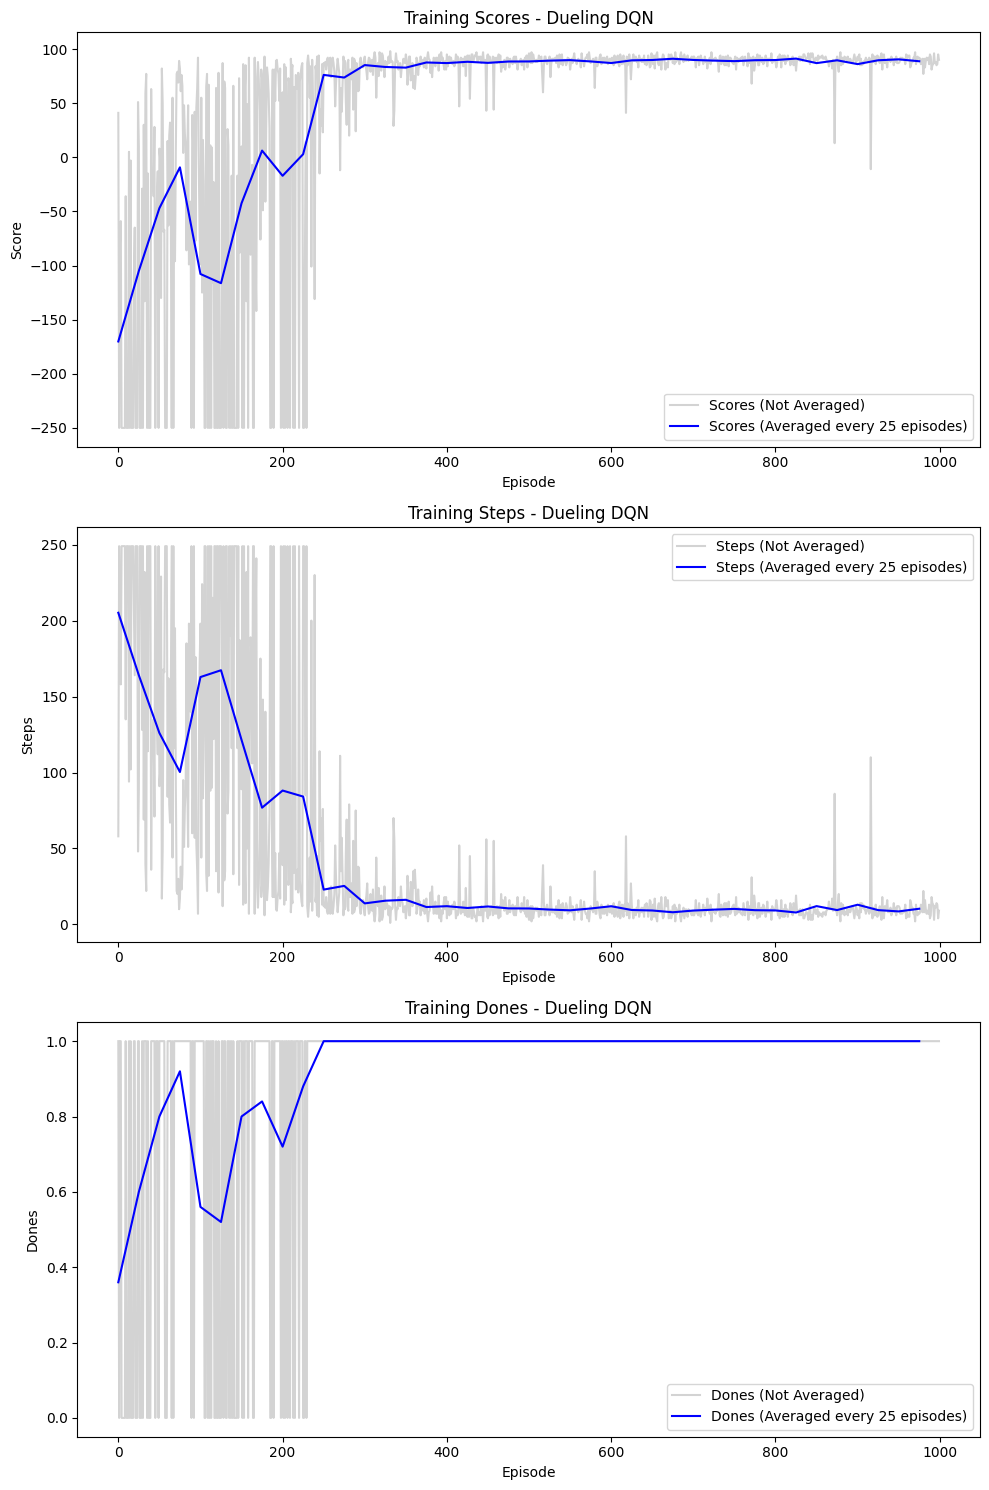

In [ ]:
# Load the model scores and steps
dueling_DQN_agent.load(path_for_agent)
scores_steps_dones = pd.read_csv(path_for_scores_steps)
print(f"Scores, steps, and dones loaded from DuelingDQN_scores_steps_{hyperparameters_str}.csv")

# Extract scores, steps, and dones
dueling_dqn_scores = scores_steps_dones["scores"].values
dueling_dqn_steps = scores_steps_dones["steps"].values
dueling_dqn_dones = scores_steps_dones["dones"].values

# Parameters for averaging
avg_every = 25

# Plot the training performance
plot_training_performance(dueling_dqn_scores, dueling_dqn_steps, dueling_dqn_dones, avg_every=avg_every, algo_name="Dueling DQN", figsize=(10, 15))

- Evaluate the Agent

In [ ]:
# Evaluate the agent
print("Evaluating the Dueling DQN agent")
dueling_dqn_scores_eval, dueling_dqn_steps_eval, dueling_dqn_dones_eval = dueling_DQN_agent.evaluate(env=env, n_episodes=50)
print(f"Dueling DQN agent's average score: {dueling_dqn_scores_eval:.2f} -- average steps: {dueling_dqn_steps_eval:.2f} -- average dones: {dueling_dqn_dones_eval:.2f}")

Evaluating the Dueling DQN agent


100%|██████████| 50/50 [00:01<00:00, 32.75it/s]

Dueling DQN agent's average score: 91.12 -- average steps: 7.88 -- average dones: 1.00


- Watch the Agent play

In [ ]:
video_filename = '/content/vid.mp4'
total_reward, step, done = save_video(dueling_DQN_agent, env, video_filename, max_steps=100)
print(f"Total reward: {total_reward} -- Steps: {step} -- Done: {done}")
embed_mp4(video_filename)

Total reward: 93 -- Steps: 7 -- Done: True


### Dueling Double DQN
- Hyperparameters
- Initialise the Agent
- Training the Agent and saving the model and training logs
- Load the model and plot the training logs
- Evaluate the Agent
- Watch the Agent play

- Hyperparameters

In [ ]:
# Agent Hyperparameters.
buffer_size = int(1e4)
batch_size = 64
gamma = 0.99 # discount factor
tau = 1e-2 # soft update of target parameters
lr = 1e-3
update_every = 4

# Set the hyperparameters string
hyperparameters_str = f"buffer_size={buffer_size}_batch_size={batch_size}_gamma={gamma}_tau={tau}_lr={lr}_update_every={update_every}"
path_for_agent = f"models_simple_DuelingDoubleDQN_{hyperparameters_str}.pth"
path_for_scores_steps = f"scores_steps_simple_DuelingDoubleDQN_scores_steps_{hyperparameters_str}.csv"



- Initialise the Agent

In [ ]:
dueling_double_DQN_agent = DQNAgent(
    state_size=state_size,
    action_size=num_actions,
    buffer_size=buffer_size,
    batch_size=batch_size,
    gamma=gamma,
    tau=tau,
    lr=lr,
    update_every=update_every,
    double_dqn=True,
    duel_dqn=True
)

- Training the Agent and saving the model and training logs

In [ ]:
# Train the agent
print("Training the Dueling Double DQN agent")
dueling_double_dqn_scores, dueling_double_dqn_steps, dueling_double_dqn_dones = dueling_double_DQN_agent.train(
    env=env,
    n_episodes=1000,
    max_t=250,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay=0.995,
    print_every=100
)
print("Finished training the Dueling Double DQN agent")

# Save the agent
dueling_double_DQN_agent.save(path_for_agent)
print(f"Dueling Double DQN agent saved as DuelingDoubleDQN_{hyperparameters_str}.pth")

# Save the scores steps and dones
scores_steps_dones = pd.DataFrame({'scores': dueling_double_dqn_scores, 'steps': dueling_double_dqn_steps, 'dones': dueling_double_dqn_dones})
scores_steps_dones.to_csv(path_for_scores_steps, index=False)
print(f"Dueling Double DQN scores, steps, and dones saved as DuelingDoubleDQN_scores_steps_{hyperparameters_str}.csv")

Training the Dueling Double DQN agent


 10%|█         | 100/1000 [01:25<09:11,  1.63it/s]

Episode 100/1000 -- Average Score: -105.95 -- Average Steps: 161.95 -- Average Dones: 0.57 -- Epsilon: 0.61


 20%|█▉        | 199/1000 [02:55<15:04,  1.13s/it]

Episode 200/1000 -- Average Score: -109.48 -- Average Steps: 159.48 -- Average Dones: 0.51 -- Epsilon: 0.37


 30%|███       | 301/1000 [03:44<01:37,  7.20it/s]

Episode 300/1000 -- Average Score: -6.80 -- Average Steps: 83.80 -- Average Dones: 0.78 -- Epsilon: 0.22


 40%|████      | 403/1000 [04:01<00:51, 11.55it/s]

Episode 400/1000 -- Average Score: 72.01 -- Average Steps: 25.99 -- Average Dones: 0.99 -- Epsilon: 0.13


 50%|█████     | 502/1000 [04:08<00:34, 14.42it/s]

Episode 500/1000 -- Average Score: 88.06 -- Average Steps: 10.94 -- Average Dones: 1.00 -- Epsilon: 0.08


 60%|██████    | 603/1000 [04:16<00:29, 13.31it/s]

Episode 600/1000 -- Average Score: 87.22 -- Average Steps: 11.78 -- Average Dones: 1.00 -- Epsilon: 0.05


 70%|███████   | 702/1000 [04:23<00:20, 14.61it/s]

Episode 700/1000 -- Average Score: 89.38 -- Average Steps: 9.62 -- Average Dones: 1.00 -- Epsilon: 0.05


 80%|████████  | 800/1000 [04:30<00:12, 16.13it/s]

Episode 800/1000 -- Average Score: 87.53 -- Average Steps: 11.47 -- Average Dones: 1.00 -- Epsilon: 0.05


 90%|█████████ | 901/1000 [04:39<00:07, 13.84it/s]

Episode 900/1000 -- Average Score: 86.00 -- Average Steps: 12.00 -- Average Dones: 0.99 -- Epsilon: 0.05


100%|██████████| 1000/1000 [04:45<00:00,  3.50it/s]

Episode 1000/1000 -- Average Score: 89.25 -- Average Steps: 9.75 -- Average Dones: 1.00 -- Epsilon: 0.05
Finished training the Dueling Double DQN agent
Dueling Double DQN agent saved as DuelingDoubleDQN_buffer_size=10000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.pth
Dueling Double DQN scores, steps, and dones saved as DuelingDoubleDQN_scores_steps_buffer_size=10000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.csv


- Load the model and the training log
- Plot the training logs

Scores, steps, and dones loaded from DuelingDoubleDQN_scores_steps_buffer_size=10000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.csv


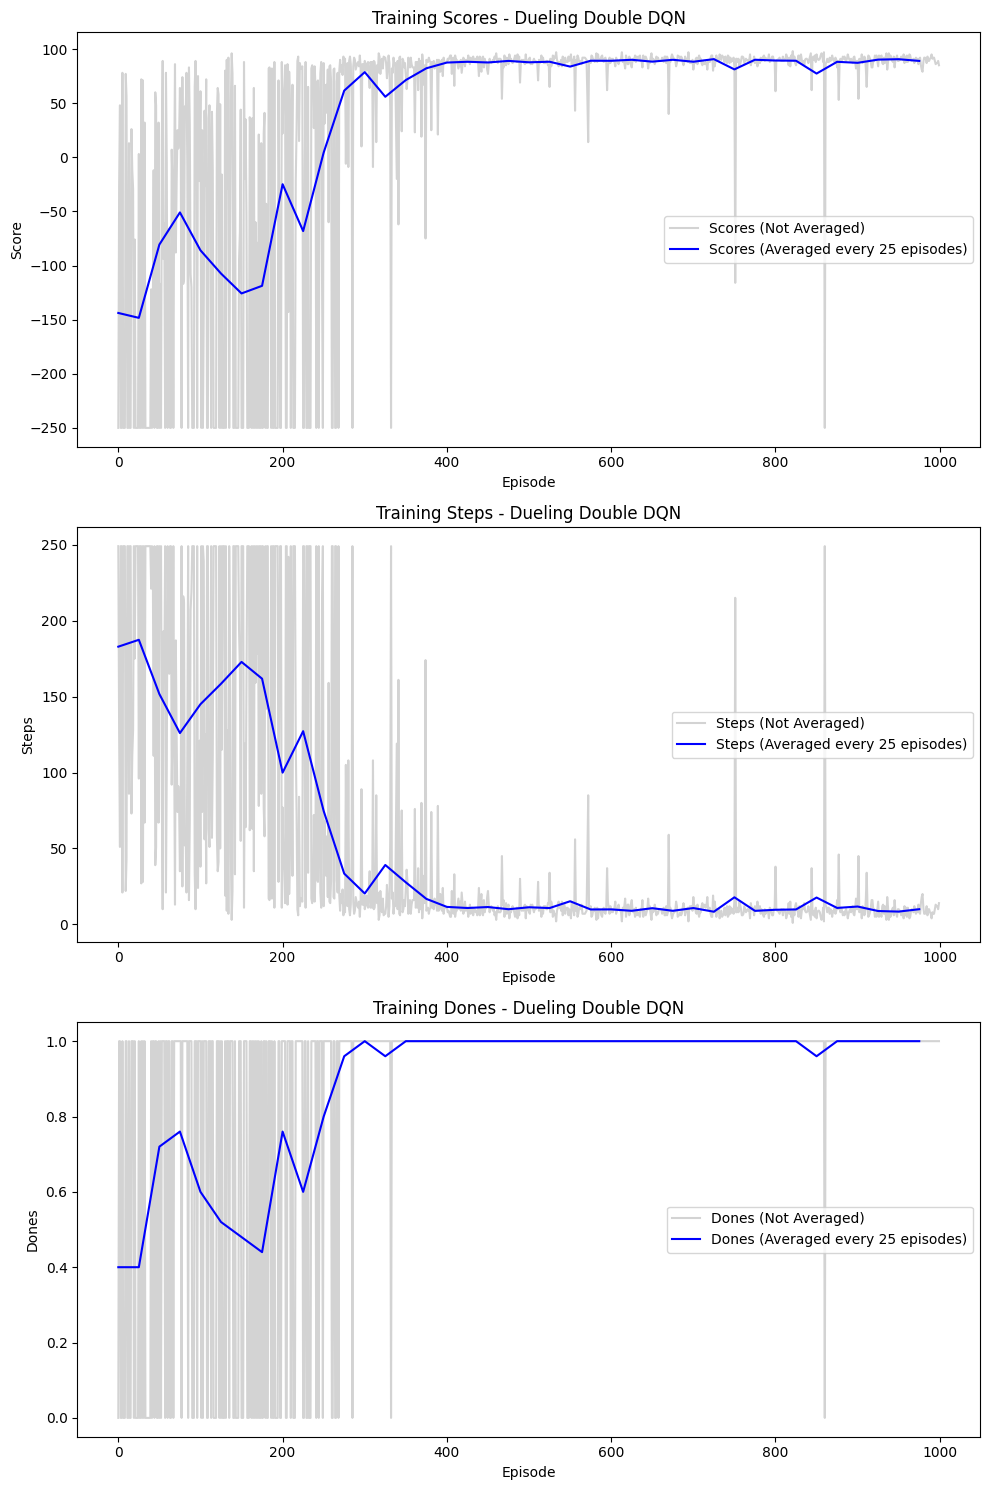

In [ ]:
# Load the model scores and steps
dueling_double_DQN_agent.load(path_for_agent)
scores_steps_dones = pd.read_csv(path_for_scores_steps)
print(f"Scores, steps, and dones loaded from DuelingDoubleDQN_scores_steps_{hyperparameters_str}.csv")

# Extract scores, steps, and dones
dueling_double_dqn_scores = scores_steps_dones["scores"].values
dueling_double_dqn_steps = scores_steps_dones["steps"].values
dueling_double_dqn_dones = scores_steps_dones["dones"].values

# Parameters for averaging
avg_every = 25

# Plot the training performance
plot_training_performance(dueling_double_dqn_scores, dueling_double_dqn_steps, dueling_double_dqn_dones, avg_every=avg_every, algo_name="Dueling Double DQN", figsize=(10, 15))


- Evaluate the Agent

In [ ]:
# Evaluate the agent
print("Evaluating the Dueling Double DQN agent")
dueling_double_dqn_scores_eval, dueling_double_dqn_steps_eval, dueling_double_dqn_dones_eval = dueling_double_DQN_agent.evaluate(env=env, n_episodes=50)
print(f"Dueling Double DQN agent's average score: {dueling_double_dqn_scores_eval:.2f} -- average steps: {dueling_double_dqn_steps_eval:.2f} -- average dones: {dueling_double_dqn_dones_eval:.2f}")


Evaluating the Dueling Double DQN agent


100%|██████████| 50/50 [00:01<00:00, 30.74it/s]

Dueling Double DQN agent's average score: 90.22 -- average steps: 8.78 -- average dones: 1.00


- Watch the Agent play

In [ ]:
video_filename = '/content/vid.mp4'
total_reward, step, done = save_video(dueling_double_DQN_agent, env, video_filename, max_steps=100)
print(f"Total reward: {total_reward} -- Steps: {step} -- Done: {done}")
embed_mp4(video_filename)

Total reward: 88 -- Steps: 12 -- Done: True


### Comparison of the 4 agents on the Empty Env

Comparing the agents training performance


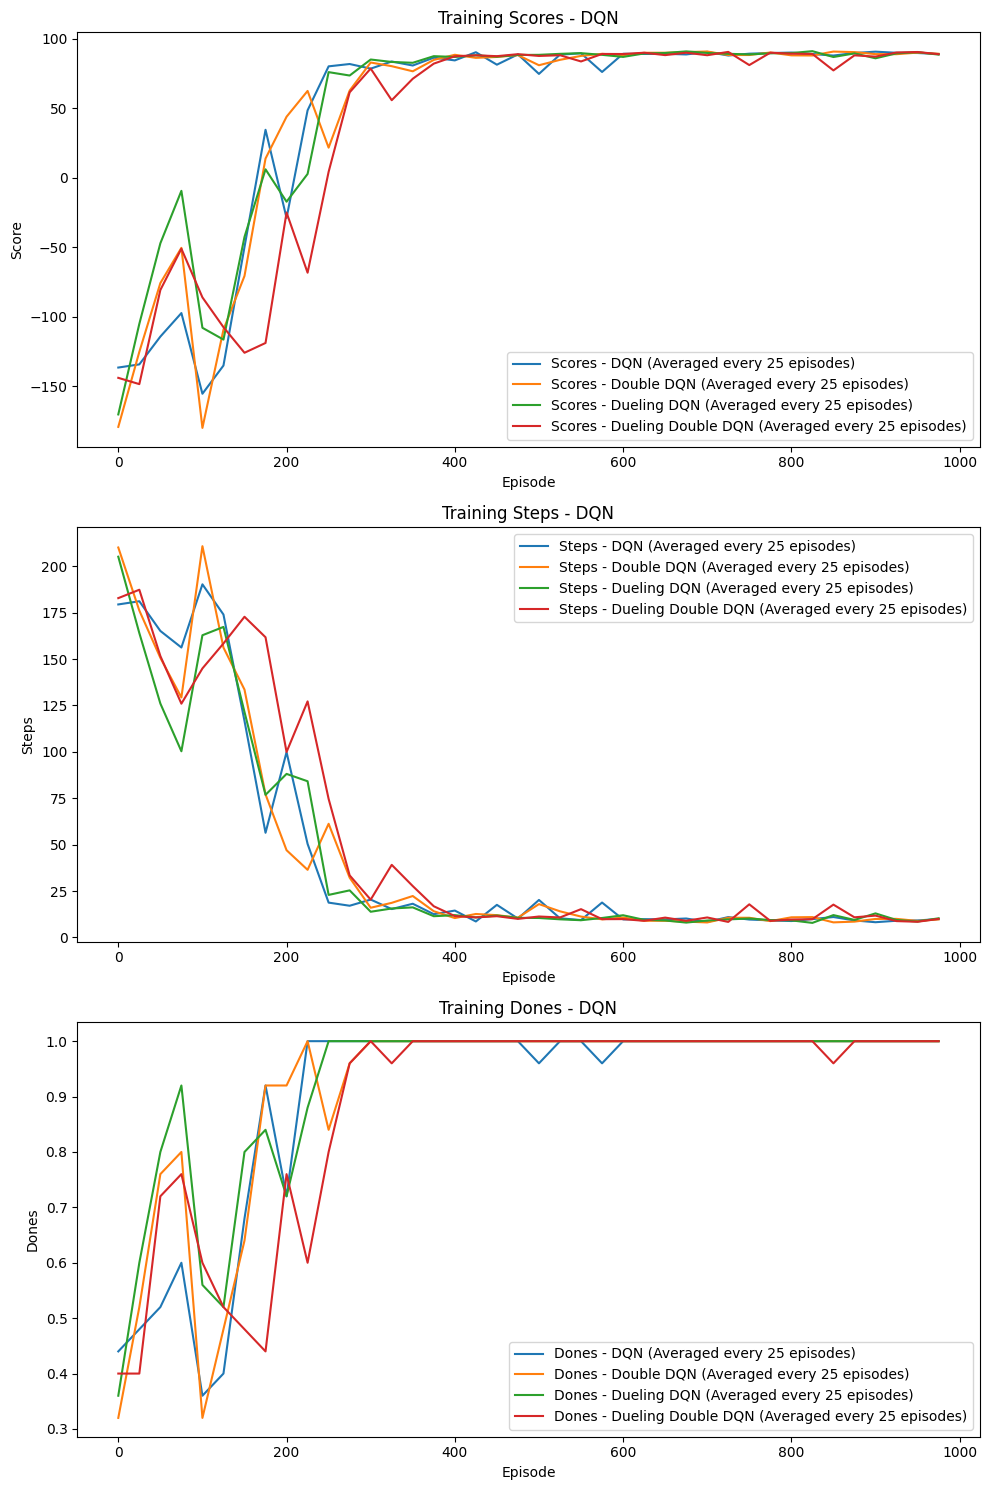

Comparing the agents evaluation performance


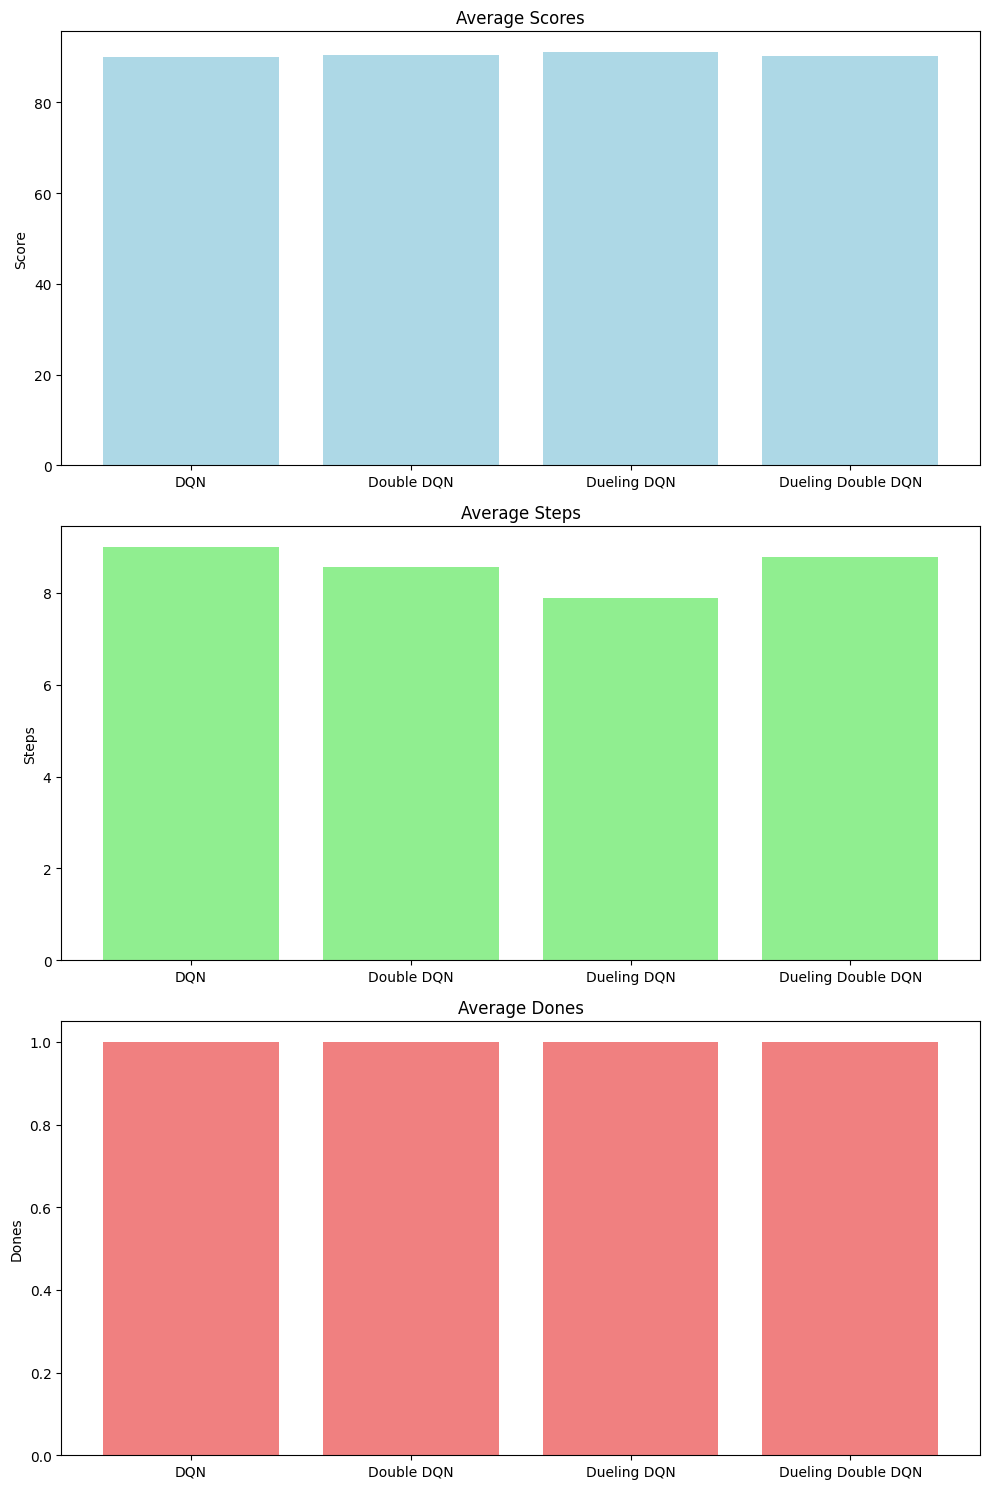

In [ ]:
# Compare the agents training performance
avg_every = 25
print("Comparing the agents training performance")
plot_training_performance_multi(
    scores_list=[dqn_scores, double_dqn_scores, dueling_dqn_scores, dueling_double_dqn_scores],
    steps_list=[dqn_steps, double_dqn_steps, dueling_dqn_steps, dueling_double_dqn_steps],
    dones_list=[dqn_dones, double_dqn_dones, dueling_dqn_dones, dueling_double_dqn_dones],
    labels=["DQN", "Double DQN", "Dueling DQN", "Dueling Double DQN"],
    avg_every=avg_every,
    figsize=(10, 15)
)

# Compare the agents evaluation performance
print("Comparing the agents evaluation performance")
plot_evaluation_performance_multi(
    scores_list=[dqn_scores_eval, double_dqn_scores_eval, dueling_dqn_scores_eval, dueling_double_dqn_scores_eval],
    steps_list=[dqn_steps_eval, double_dqn_steps_eval, dueling_dqn_steps_eval, dueling_double_dqn_steps_eval],
    dones_list=[dqn_dones_eval, double_dqn_dones_eval, dueling_dqn_dones_eval, dueling_double_dqn_dones_eval],
    labels=["DQN", "Double DQN", "Dueling DQN", "Dueling Double DQN"],
    figsize=(10, 15)
)

## Training the Agent on the Key Env

In [ ]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPU if it's available
print(f"Device: {device}")

# SEED for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Initialize the environment
env = KEYRGBImgObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'), preprocess=pre_process)
obs = env.reset()[0] # 64x64x1
state_size = obs.shape  # 64x64x1
action_space = env.action_space # Discrete(5)
num_actions = action_space.n # 5

Device: cuda


### DQN
- Hyperparameters
- Initialise the Agent
- Training the Agent and saving the model and training logs
- Load the model and plot the training logs
- Evaluate the Agent
- Watch the Agent play

- Hyperparameters

In [ ]:
# Agent Hyperparameters.
buffer_size = int(1e5)
batch_size = 64
gamma = 0.99 # discount factor
tau = 1e-2 # soft update of target parameters
lr = 1e-3
update_every = 4

# Set the hyperparameters string
hyperparameters_str = f"buffer_size={buffer_size}_batch_size={batch_size}_gamma={gamma}_tau={tau}_lr={lr}_update_every={update_every}"
path_for_agent = f"models_key_DQN_{hyperparameters_str}.pth"
path_for_scores_steps = f"scores_steps_key_DQN_scores_steps_{hyperparameters_str}.csv"

- Initialise the Agent

In [ ]:
# Initialize the agent
DQN_agent_key = DQNAgent(
    state_size=state_size,
    action_size=num_actions,
    buffer_size=buffer_size,
    batch_size=batch_size,
    gamma=gamma,
    tau=tau,
    lr=lr,
    update_every=update_every,
    double_dqn=False,
    duel_dqn=False
)

- Training the Agent and saving the model and training logs

In [ ]:
# Train the agent
print("Training the DQN agent")
dqn_scores_key, dqn_steps_key, dqn_dones_key = DQN_agent_key.train(
    env=env,
    n_episodes=1000,
    max_t=2000,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay=0.997,
    print_every=100
)
print("Finished training the DQN agent")

# Save the agent
DQN_agent_key.save(path_for_agent)
print(f"DQN agent saved as DQN_{hyperparameters_str}.pth")

# Save the scores steps and dones
scores_steps_dones = pd.DataFrame({'scores': dqn_scores_key, 'steps': dqn_steps_key, 'dones': dqn_dones_key})
scores_steps_dones.to_csv(path_for_scores_steps, index=False)
print(f"DQN scores, steps, and dones saved as DQN_scores_steps_{hyperparameters_str}.csv")

Training the DQN agent


 10%|█         | 100/1000 [10:57<1:56:27,  7.76s/it]

Episode 100/1000 -- Average Score: -86.31 -- Average Steps: 1516.06 -- Average Dones: 0.48 -- Epsilon: 0.74


 20%|██        | 201/1000 [20:37<33:43,  2.53s/it]

Episode 200/1000 -- Average Score: -54.64 -- Average Steps: 1262.42 -- Average Dones: 0.55 -- Epsilon: 0.55


 30%|███       | 300/1000 [27:04<29:36,  2.54s/it]

Episode 300/1000 -- Average Score: 14.90 -- Average Steps: 831.02 -- Average Dones: 0.79 -- Epsilon: 0.41


 40%|████      | 400/1000 [31:11<32:44,  3.27s/it]

Episode 400/1000 -- Average Score: 56.91 -- Average Steps: 517.88 -- Average Dones: 0.90 -- Epsilon: 0.30


 50%|█████     | 500/1000 [32:40<05:53,  1.42it/s]

Episode 500/1000 -- Average Score: 100.46 -- Average Steps: 181.37 -- Average Dones: 0.99 -- Epsilon: 0.22


 60%|██████    | 600/1000 [33:53<06:48,  1.02s/it]

Episode 600/1000 -- Average Score: 105.05 -- Average Steps: 148.51 -- Average Dones: 1.00 -- Epsilon: 0.16


 70%|███████   | 701/1000 [34:56<04:18,  1.16it/s]

Episode 700/1000 -- Average Score: 106.19 -- Average Steps: 125.12 -- Average Dones: 0.99 -- Epsilon: 0.12


 80%|████████  | 800/1000 [35:29<00:44,  4.46it/s]

Episode 800/1000 -- Average Score: 113.40 -- Average Steps: 65.00 -- Average Dones: 1.00 -- Epsilon: 0.09


 90%|█████████ | 900/1000 [36:01<00:47,  2.10it/s]

Episode 900/1000 -- Average Score: 113.66 -- Average Steps: 62.38 -- Average Dones: 1.00 -- Epsilon: 0.07


100%|██████████| 1000/1000 [36:29<00:00,  2.19s/it]

Episode 1000/1000 -- Average Score: 113.82 -- Average Steps: 60.79 -- Average Dones: 1.00 -- Epsilon: 0.05
Finished training the DQN agent
DQN agent saved as DQN_buffer_size=100000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.pth
DQN scores, steps, and dones saved as DQN_scores_steps_buffer_size=100000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.csv


- Load the model and the training log
- Plot the training logs

Scores, steps, and dones loaded from DQN_scores_steps_buffer_size=100000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.csv


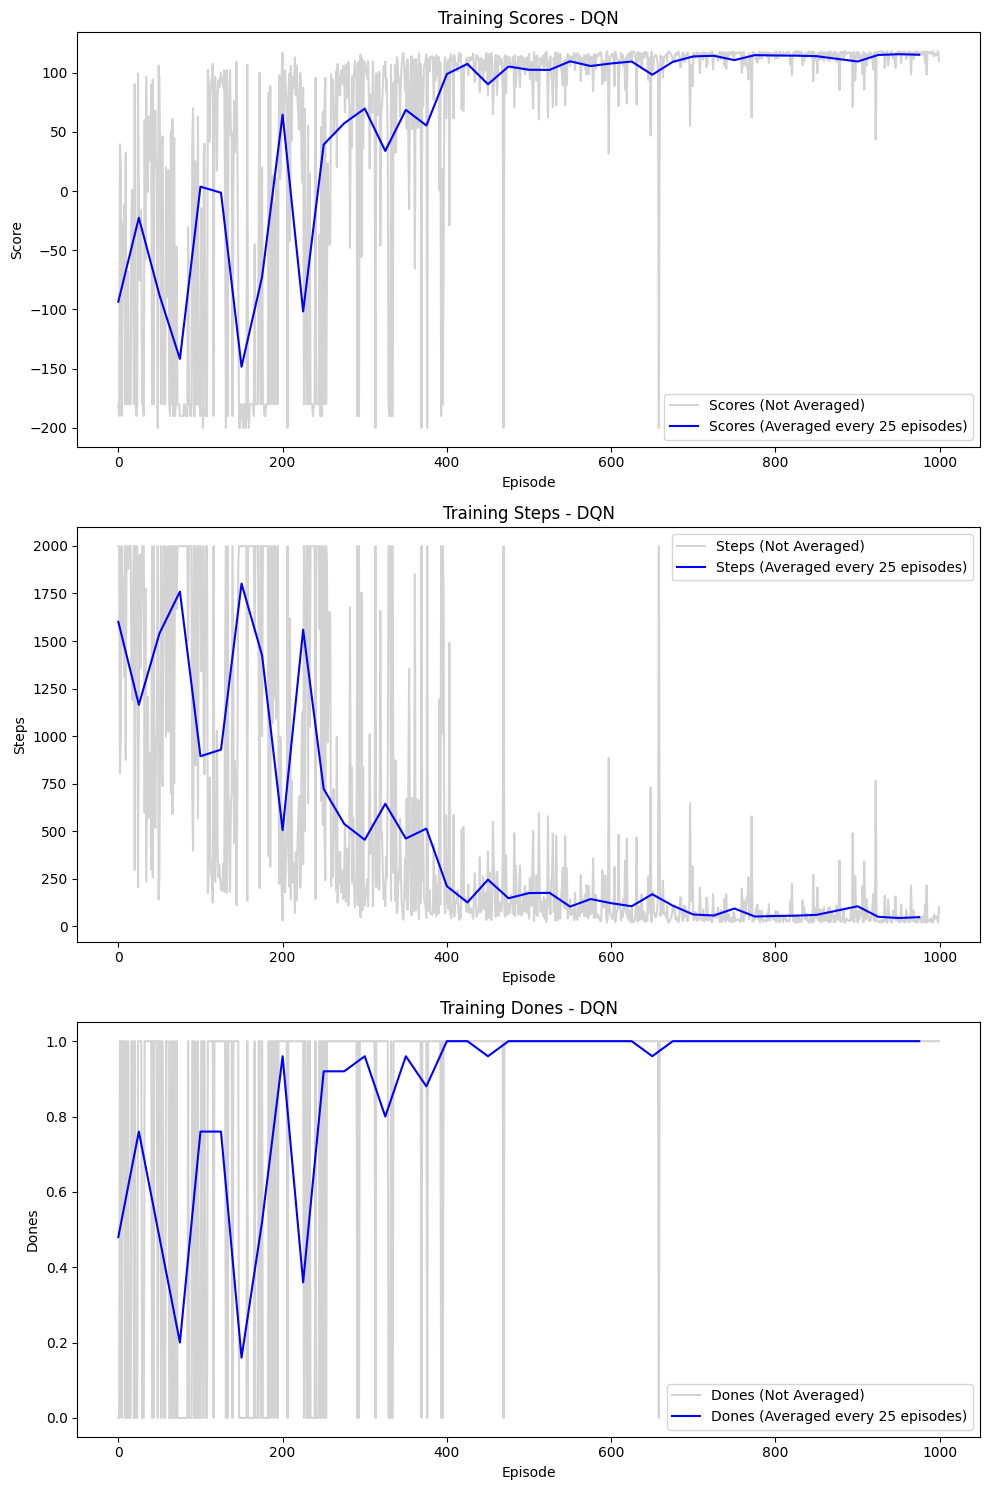

In [ ]:
# Load the model scores and steps
DQN_agent_key.load(path_for_agent)
scores_steps_dones = pd.read_csv(path_for_scores_steps)
print(f"Scores, steps, and dones loaded from DQN_scores_steps_{hyperparameters_str}.csv")

# Extract scores, steps, and dones
dqn_scores_key = scores_steps_dones["scores"].values
dqn_steps_key = scores_steps_dones["steps"].values
dqn_dones_key = scores_steps_dones["dones"].values

# Parameters for averaging
avg_every = 25

# Plot the training performance
plot_training_performance(dqn_scores_key, dqn_steps_key, dqn_dones_key, avg_every=avg_every, algo_name="DQN", figsize=(10, 15))

- Evaluate the Agent

In [ ]:
# Evaluate the agent
print("Evaluating the DQN agent")
dqn_scores_eval_key, dqn_steps_eval_key, dqn_dones_eval_key = DQN_agent_key.evaluate(env=env, n_episodes=50)
print(f"DQN agent's average score: {dqn_scores_eval_key:.2f} -- average steps: {dqn_steps_eval_key:.2f} -- average dones: {dqn_dones_eval_key:.2f}")


Evaluating the DQN agent


100%|██████████| 50/50 [00:47<00:00,  1.05it/s]

DQN agent's average score: 44.24 -- average steps: 354.60 -- average dones: 0.66


- Watch the Agent play

In [ ]:
video_filename = '/content/vid.mp4'
total_reward, step, done = save_video(DQN_agent_key, env, video_filename, max_steps=1000)
print(f"Total reward: {total_reward} -- Steps: {step} -- Done: {done}")
embed_mp4(video_filename)

Total reward: 118.0 -- Steps: 20 -- Done: True


### Double DQN
- Hyperparameters
- Initialise the Agent
- Training the Agent and saving the model and training logs
- Load the model and plot the training logs
- Evaluate the Agent


- Hyperparameters

In [ ]:
# Agent Hyperparameters.
buffer_size = int(1e5)
batch_size = 64
gamma = 0.99 # discount factor
tau = 1e-2 # soft update of target parameters
lr = 1e-3
update_every = 4

# Set the hyperparameters string
hyperparameters_str = f"buffer_size={buffer_size}_batch_size={batch_size}_gamma={gamma}_tau={tau}_lr={lr}_update_every={update_every}"
path_for_agent = f"models_key_DoubleDQN_{hyperparameters_str}.pth"
path_for_scores_steps = f"scores_steps_key_DoubleDQN_scores_steps_{hyperparameters_str}.csv"

- Initialise the agent

In [ ]:
double_DQN_agent_key = DQNAgent(
    state_size=state_size,
    action_size=num_actions,
    buffer_size=buffer_size,
    batch_size=batch_size,
    gamma=gamma,
    tau=tau,
    lr=lr,
    update_every=update_every,
    double_dqn=True,
    duel_dqn=False
)

- Training the agent and saving the model and training logs

In [ ]:
# Train the agent
print("Training the Double DQN agent")
double_dqn_scores_key, double_dqn_steps_key, double_dqn_dones_key = double_DQN_agent_key.train(
    env=env,
    n_episodes=1000,
    max_t=2000,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay=0.997,
    print_every=100
)
print("Finished training the Double DQN agent")

# Save the agent
double_DQN_agent_key.save(path_for_agent)
print(f"Double DQN agent saved as DoubleDQN_{hyperparameters_str}.pth")

# Save the scores steps and dones
scores_steps_dones = pd.DataFrame({'scores': double_dqn_scores_key, 'steps': double_dqn_steps_key, 'dones': double_dqn_dones_key})
scores_steps_dones.to_csv(path_for_scores_steps, index=False)
print(f"Double DQN scores, steps, and dones saved as DoubleDQN_scores_steps_{hyperparameters_str}.csv")

Training the Double DQN agent


 10%|█         | 100/1000 [08:50<33:54,  2.26s/it]

Episode 100/1000 -- Average Score: -41.47 -- Average Steps: 1268.75 -- Average Dones: 0.68 -- Epsilon: 0.74


 20%|██        | 200/1000 [13:00<41:01,  3.08s/it]

Episode 200/1000 -- Average Score: 52.44 -- Average Steps: 577.62 -- Average Dones: 0.92 -- Epsilon: 0.55


 30%|███       | 300/1000 [15:31<14:43,  1.26s/it]

Episode 300/1000 -- Average Score: 79.54 -- Average Steps: 335.58 -- Average Dones: 0.94 -- Epsilon: 0.41


 40%|████      | 400/1000 [17:03<05:30,  1.82it/s]

Episode 400/1000 -- Average Score: 95.84 -- Average Steps: 197.58 -- Average Dones: 0.96 -- Epsilon: 0.30


 50%|█████     | 500/1000 [17:29<02:30,  3.33it/s]

Episode 500/1000 -- Average Score: 114.68 -- Average Steps: 52.24 -- Average Dones: 1.00 -- Epsilon: 0.22


 60%|██████    | 601/1000 [18:00<01:51,  3.58it/s]

Episode 600/1000 -- Average Score: 113.56 -- Average Steps: 63.42 -- Average Dones: 1.00 -- Epsilon: 0.16


 70%|███████   | 701/1000 [18:21<00:56,  5.25it/s]

Episode 700/1000 -- Average Score: 115.64 -- Average Steps: 42.55 -- Average Dones: 1.00 -- Epsilon: 0.12


 80%|████████  | 800/1000 [18:42<01:43,  1.93it/s]

Episode 800/1000 -- Average Score: 115.67 -- Average Steps: 42.29 -- Average Dones: 1.00 -- Epsilon: 0.09


 90%|█████████ | 901/1000 [18:59<00:13,  7.32it/s]

Episode 900/1000 -- Average Score: 116.57 -- Average Steps: 33.26 -- Average Dones: 1.00 -- Epsilon: 0.07


100%|██████████| 1000/1000 [19:13<00:00,  1.15s/it]

Episode 1000/1000 -- Average Score: 117.15 -- Average Steps: 27.47 -- Average Dones: 1.00 -- Epsilon: 0.05
Finished training the Double DQN agent
Double DQN agent saved as DoubleDQN_buffer_size=100000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.pth
Double DQN scores, steps, and dones saved as DoubleDQN_scores_steps_buffer_size=100000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.csv


- Load the model and the training log
- Plot the training logs

Scores, steps, and dones loaded from DoubleDQN_scores_steps_buffer_size=100000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.csv


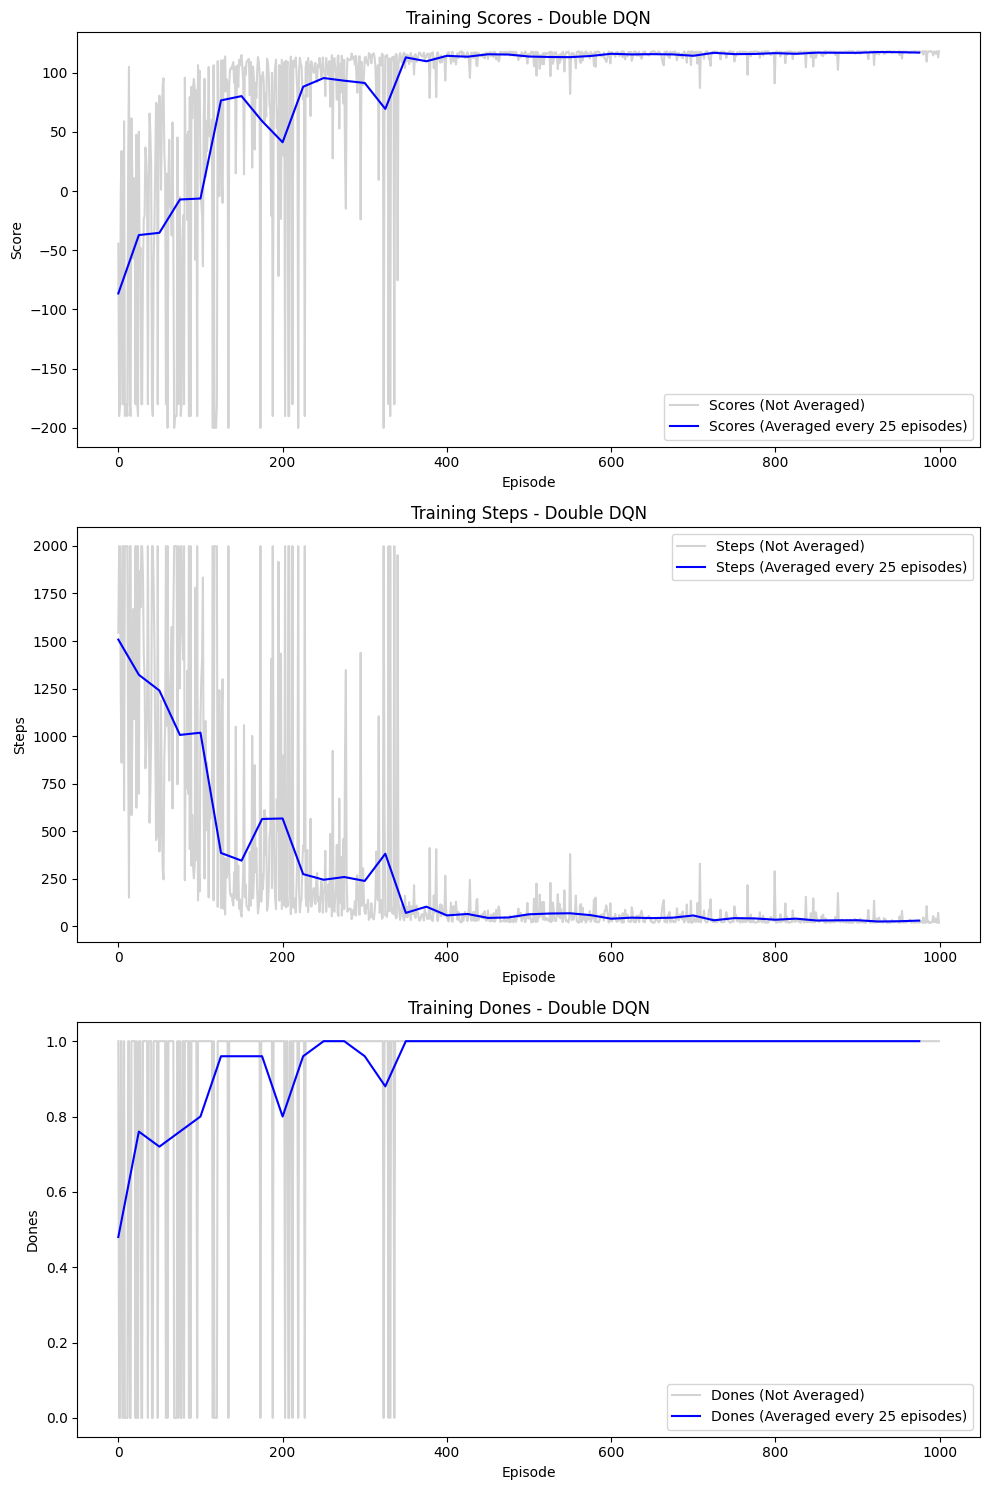

In [ ]:
# Load the model scores and steps
double_DQN_agent_key.load(path_for_agent)
scores_steps_dones = pd.read_csv(path_for_scores_steps)
print(f"Scores, steps, and dones loaded from DoubleDQN_scores_steps_{hyperparameters_str}.csv")

# Extract scores, steps, and dones
double_dqn_scores_key = scores_steps_dones["scores"].values
double_dqn_steps_key = scores_steps_dones["steps"].values
double_dqn_dones_key = scores_steps_dones["dones"].values

# Parameters for averaging
avg_every = 25

# Plot the training performance
plot_training_performance(double_dqn_scores_key, double_dqn_steps_key, double_dqn_dones_key, avg_every=avg_every, algo_name="Double DQN", figsize=(10, 15))

- Evaluate the agent

In [ ]:
# Evaluate the agent
print("Evaluating the Double DQN agent")
double_dqn_scores_eval_key, double_dqn_steps_eval_key, double_dqn_dones_eval_key = double_DQN_agent_key.evaluate(env=env, n_episodes=50)
print(f"Double DQN agent's average score: {double_dqn_scores_eval_key:.2f} -- average steps: {double_dqn_steps_eval_key:.2f} -- average dones: {double_dqn_dones_eval_key:.2f}")

Evaluating the Double DQN agent


100%|██████████| 50/50 [00:39<00:00,  1.28it/s]

Double DQN agent's average score: 56.78 -- average steps: 295.22 -- average dones: 0.72


- Watch the Agent play

In [ ]:
video_filename = '/content/vid.mp4'
total_reward, step, done = save_video(double_DQN_agent_key, env, video_filename, max_steps=1000)
print(f"Total reward: {total_reward} -- Steps: {step} -- Done: {done}")
embed_mp4(video_filename)

Total reward: 118.1 -- Steps: 19 -- Done: True


### Dueling DQN
- Hyperparameters
- Initialise the Agent
- Training the Agent and saving the model and training logs
- Load the model and plot the training logs
- Evaluate the Agent
- Watch the Agent play

- Hyperparameters

In [ ]:
# Agent Hyperparameters.
buffer_size = int(1e5)
batch_size = 64
gamma = 0.99 # discount factor
tau = 1e-2 # soft update of target parameters
lr = 1e-3
update_every = 4

# Set the hyperparameters string
hyperparameters_str = f"buffer_size={buffer_size}_batch_size={batch_size}_gamma={gamma}_tau={tau}_lr={lr}_update_every={update_every}"
path_for_agent = f"models_key_DuelingDQN_{hyperparameters_str}.pth"
path_for_scores_steps = f"scores_steps_key_DuelingDQN_scores_steps_{hyperparameters_str}.csv"



- Initialise the Agent

In [ ]:
dueling_DQN_agent_key = DQNAgent(
    state_size=state_size,
    action_size=num_actions,
    buffer_size=buffer_size,
    batch_size=batch_size,
    gamma=gamma,
    tau=tau,
    lr=lr,
    update_every=update_every,
    double_dqn=False,
    duel_dqn=True
)

- Training the Agent and saving the model and training logs

In [ ]:
# Train the agent
print("Training the Dueling DQN agent")
dueling_dqn_scores_key, dueling_dqn_steps_key, dueling_dqn_dones_key = dueling_DQN_agent_key.train(
    env=env,
    n_episodes=1000,
    max_t=2000,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay=0.997,
    print_every=100
)
print("Finished training the Dueling DQN agent")

# Save the agent
dueling_DQN_agent_key.save(path_for_agent)
print(f"Dueling DQN agent saved as DuelingDQN_{hyperparameters_str}.pth")

# Save the scores steps and dones
scores_steps_dones = pd.DataFrame({'scores': dueling_dqn_scores_key, 'steps': dueling_dqn_steps_key, 'dones': dueling_dqn_dones_key})
scores_steps_dones.to_csv(path_for_scores_steps, index=False)
print(f"Dueling DQN scores, steps, and dones saved as DuelingDQN_scores_steps_{hyperparameters_str}.csv")

Training the Dueling DQN agent


 10%|█         | 100/1000 [09:38<1:25:38,  5.71s/it]

Episode 100/1000 -- Average Score: -62.70 -- Average Steps: 1398.00 -- Average Dones: 0.60 -- Epsilon: 0.74


 20%|██        | 200/1000 [16:24<1:21:14,  6.09s/it]

Episode 200/1000 -- Average Score: -6.41 -- Average Steps: 950.07 -- Average Dones: 0.71 -- Epsilon: 0.55


 30%|███       | 300/1000 [22:09<29:49,  2.56s/it]

Episode 300/1000 -- Average Score: 19.48 -- Average Steps: 766.21 -- Average Dones: 0.78 -- Epsilon: 0.41


 40%|████      | 400/1000 [24:13<04:31,  2.21it/s]

Episode 400/1000 -- Average Score: 88.92 -- Average Steps: 263.81 -- Average Dones: 0.96 -- Epsilon: 0.30


 50%|█████     | 501/1000 [25:19<05:37,  1.48it/s]

Episode 500/1000 -- Average Score: 106.57 -- Average Steps: 133.34 -- Average Dones: 1.00 -- Epsilon: 0.22


 60%|██████    | 600/1000 [26:04<02:27,  2.72it/s]

Episode 600/1000 -- Average Score: 110.80 -- Average Steps: 91.04 -- Average Dones: 1.00 -- Epsilon: 0.16


 70%|███████   | 700/1000 [26:48<03:15,  1.53it/s]

Episode 700/1000 -- Average Score: 111.20 -- Average Steps: 87.00 -- Average Dones: 1.00 -- Epsilon: 0.12


 80%|████████  | 801/1000 [27:24<00:29,  6.80it/s]

Episode 800/1000 -- Average Score: 111.76 -- Average Steps: 69.41 -- Average Dones: 0.99 -- Epsilon: 0.09


 90%|█████████ | 900/1000 [28:05<00:36,  2.77it/s]

Episode 900/1000 -- Average Score: 111.63 -- Average Steps: 82.66 -- Average Dones: 1.00 -- Epsilon: 0.07


100%|██████████| 1000/1000 [28:33<00:00,  1.71s/it]

Episode 1000/1000 -- Average Score: 114.54 -- Average Steps: 53.58 -- Average Dones: 1.00 -- Epsilon: 0.05
Finished training the Dueling DQN agent
Dueling DQN agent saved as DuelingDQN_buffer_size=100000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.pth
Dueling DQN scores, steps, and dones saved as DuelingDQN_scores_steps_buffer_size=100000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.csv


- Load the model and the training log
- Plot the training logs

Scores, steps, and dones loaded from DuelingDQN_scores_steps_buffer_size=100000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.csv


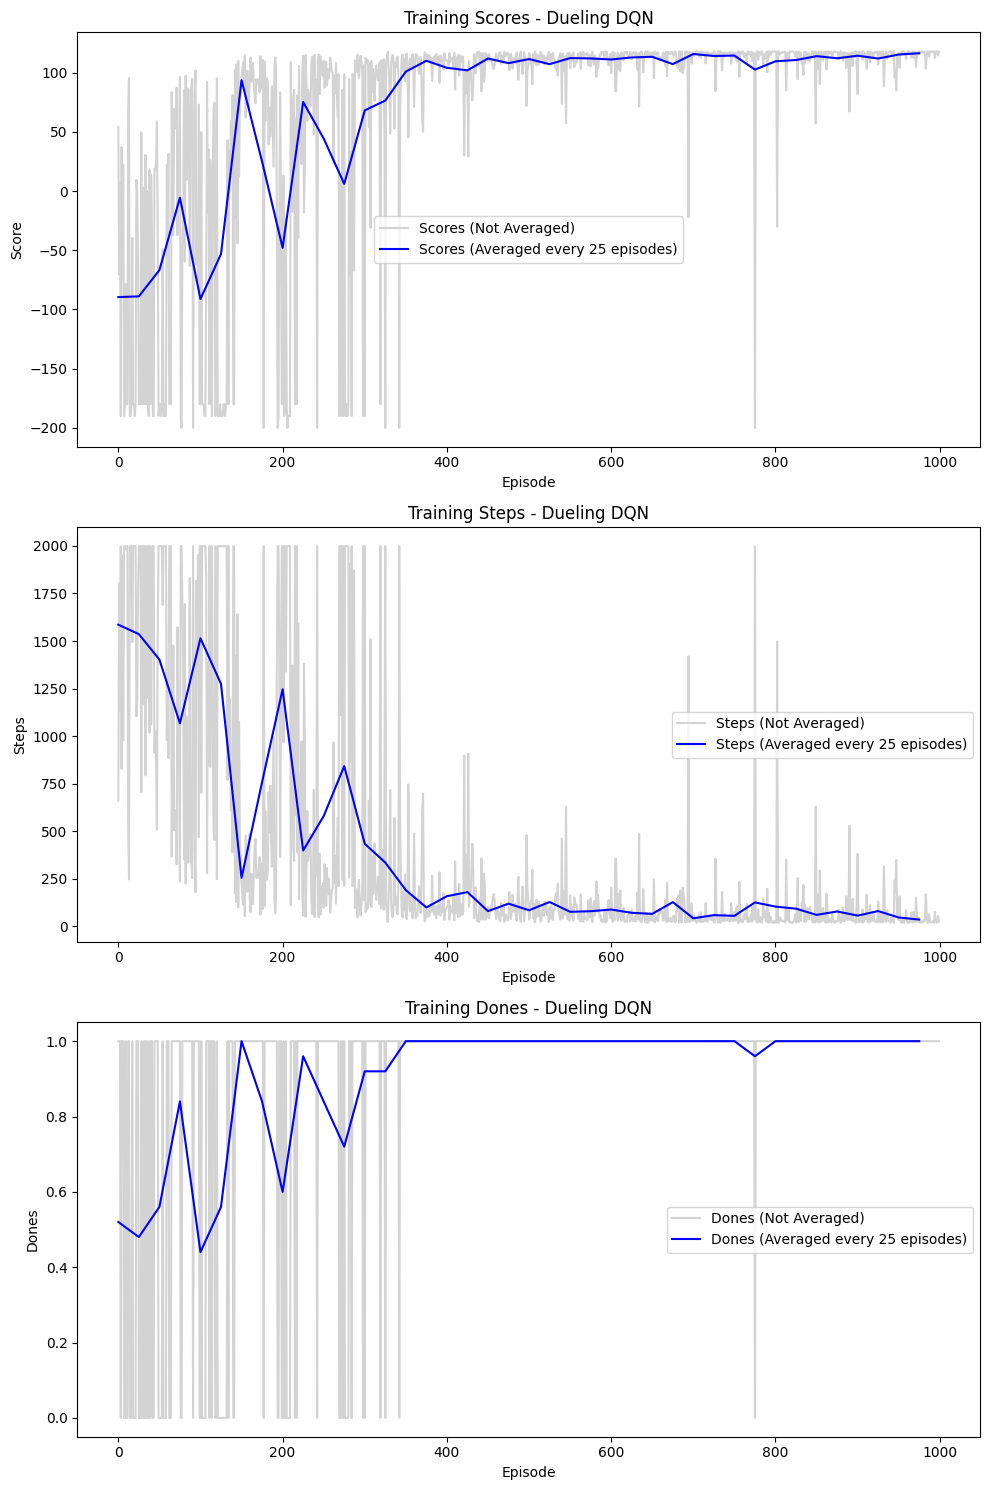

In [ ]:
# Load the model scores and steps
dueling_DQN_agent_key.load(path_for_agent)
scores_steps_dones = pd.read_csv(path_for_scores_steps)
print(f"Scores, steps, and dones loaded from DuelingDQN_scores_steps_{hyperparameters_str}.csv")

# Extract scores, steps, and dones
dueling_dqn_scores_key = scores_steps_dones["scores"].values
dueling_dqn_steps_key = scores_steps_dones["steps"].values
dueling_dqn_dones_key = scores_steps_dones["dones"].values

# Parameters for averaging
avg_every = 25

# Plot the training performance
plot_training_performance(dueling_dqn_scores_key, dueling_dqn_steps_key, dueling_dqn_dones_key, avg_every=avg_every, algo_name="Dueling DQN", figsize=(10, 15))


- Evaluate the Agent

In [ ]:
# Evaluate the agent
print("Evaluating the Dueling DQN agent")
dueling_dqn_scores_eval_key, dueling_dqn_steps_eval_key, dueling_dqn_dones_eval_key = dueling_DQN_agent_key.evaluate(env=env, n_episodes=50)
print(f"Dueling DQN agent's average score: {dueling_dqn_scores_eval_key:.2f} -- average steps: {dueling_dqn_steps_eval_key:.2f} -- average dones: {dueling_dqn_dones_eval_key:.2f}")

Evaluating the Dueling DQN agent


100%|██████████| 50/50 [00:37<00:00,  1.34it/s]

Dueling DQN agent's average score: 66.72 -- average steps: 255.84 -- average dones: 0.76


- Watch the Agent play

In [ ]:
video_filename = '/content/vid.mp4'
total_reward, step, done = save_video(dueling_DQN_agent_key, env, video_filename, max_steps=1000)
print(f"Total reward: {total_reward} -- Steps: {step} -- Done: {done}")
embed_mp4(video_filename)

Total reward: 117.29999999999998 -- Steps: 27 -- Done: True


### Dueling Double DQN
- Hyperparameters
- Initialise the Agent
- Training the Agent and saving the model and training logs
- Load the model and plot the training logs

- Hyperparameters

In [ ]:
# Agent Hyperparameters.
buffer_size = int(1e5)
batch_size = 64
gamma = 0.99 # discount factor
tau = 1e-2 # soft update of target parameters
lr = 1e-3
update_every = 4

# Set the hyperparameters string
hyperparameters_str = f"buffer_size={buffer_size}_batch_size={batch_size}_gamma={gamma}_tau={tau}_lr={lr}_update_every={update_every}"
path_for_agent = f"models_key_DuelingDoubleDQN_{hyperparameters_str}.pth"
path_for_scores_steps = f"scores_steps_key_DuelingDoubleDQN_scores_steps_{hyperparameters_str}.csv"

- Initialise the Agent

In [ ]:
# Initialize the agent
dueling_double_DQN_agent_key = DQNAgent(
    state_size=state_size,
    action_size=num_actions,
    buffer_size=buffer_size,
    batch_size=batch_size,
    gamma=gamma,
    tau=tau,
    lr=lr,
    update_every=update_every,
    double_dqn=True,
    duel_dqn=True
)


- Training the Agent and saving the model and training logs

In [ ]:
# Train the agent
print("Training the Dueling Double DQN agent")
dueling_double_dqn_scores_key, dueling_double_dqn_steps_key, dueling_double_dqn_dones_key = dueling_double_DQN_agent_key.train(
    env=env,
    n_episodes=1000,
    max_t=2000,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay=0.997,
    print_every=100
)
print("Finished training the Dueling Double DQN agent")

# Save the agent
dueling_double_DQN_agent_key.save(path_for_agent)
print(f"Dueling Double DQN agent saved as DuelingDoubleDQN_{hyperparameters_str}.pth")

# Save the scores steps and dones
scores_steps_dones = pd.DataFrame({'scores': dueling_double_dqn_scores_key, 'steps': dueling_double_dqn_steps_key, 'dones': dueling_double_dqn_dones_key})
scores_steps_dones.to_csv(path_for_scores_steps, index=False)
print(f"Dueling Double DQN scores, steps, and dones saved as DuelingDoubleDQN_scores_steps_{hyperparameters_str}.csv")


Training the Dueling Double DQN agent


 10%|█         | 100/1000 [10:56<1:23:23,  5.56s/it]

Episode 100/1000 -- Average Score: -61.29 -- Average Steps: 1400.86 -- Average Dones: 0.61 -- Epsilon: 0.74


 20%|██        | 200/1000 [14:54<08:25,  1.58it/s]

Episode 200/1000 -- Average Score: 64.24 -- Average Steps: 493.57 -- Average Dones: 0.94 -- Epsilon: 0.55


 30%|███       | 300/1000 [16:23<06:14,  1.87it/s]

Episode 300/1000 -- Average Score: 102.06 -- Average Steps: 177.45 -- Average Dones: 1.00 -- Epsilon: 0.41


 40%|████      | 400/1000 [17:48<05:24,  1.85it/s]

Episode 400/1000 -- Average Score: 103.32 -- Average Steps: 162.80 -- Average Dones: 1.00 -- Epsilon: 0.30


 50%|█████     | 500/1000 [18:18<01:30,  5.51it/s]

Episode 500/1000 -- Average Score: 114.51 -- Average Steps: 53.85 -- Average Dones: 1.00 -- Epsilon: 0.22


 60%|██████    | 601/1000 [18:47<01:55,  3.44it/s]

Episode 600/1000 -- Average Score: 114.79 -- Average Steps: 51.08 -- Average Dones: 1.00 -- Epsilon: 0.16


 70%|███████   | 700/1000 [19:16<00:48,  6.16it/s]

Episode 700/1000 -- Average Score: 114.58 -- Average Steps: 53.24 -- Average Dones: 1.00 -- Epsilon: 0.12


 80%|████████  | 801/1000 [19:37<00:26,  7.46it/s]

Episode 800/1000 -- Average Score: 116.38 -- Average Steps: 35.19 -- Average Dones: 1.00 -- Epsilon: 0.09


 90%|█████████ | 901/1000 [19:55<00:15,  6.54it/s]

Episode 900/1000 -- Average Score: 116.93 -- Average Steps: 29.74 -- Average Dones: 1.00 -- Epsilon: 0.07


100%|██████████| 1000/1000 [20:15<00:00,  1.22s/it]

Episode 1000/1000 -- Average Score: 116.99 -- Average Steps: 29.10 -- Average Dones: 1.00 -- Epsilon: 0.05
Finished training the Dueling Double DQN agent
Dueling Double DQN agent saved as DuelingDoubleDQN_buffer_size=100000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.pth
Dueling Double DQN scores, steps, and dones saved as DuelingDoubleDQN_scores_steps_buffer_size=100000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.csv


- Load the model and the training log
- Plot the training logs

Scores, steps, and dones loaded from DuelingDoubleDQN_scores_steps_buffer_size=100000_batch_size=64_gamma=0.99_tau=0.01_lr=0.001_update_every=4.csv


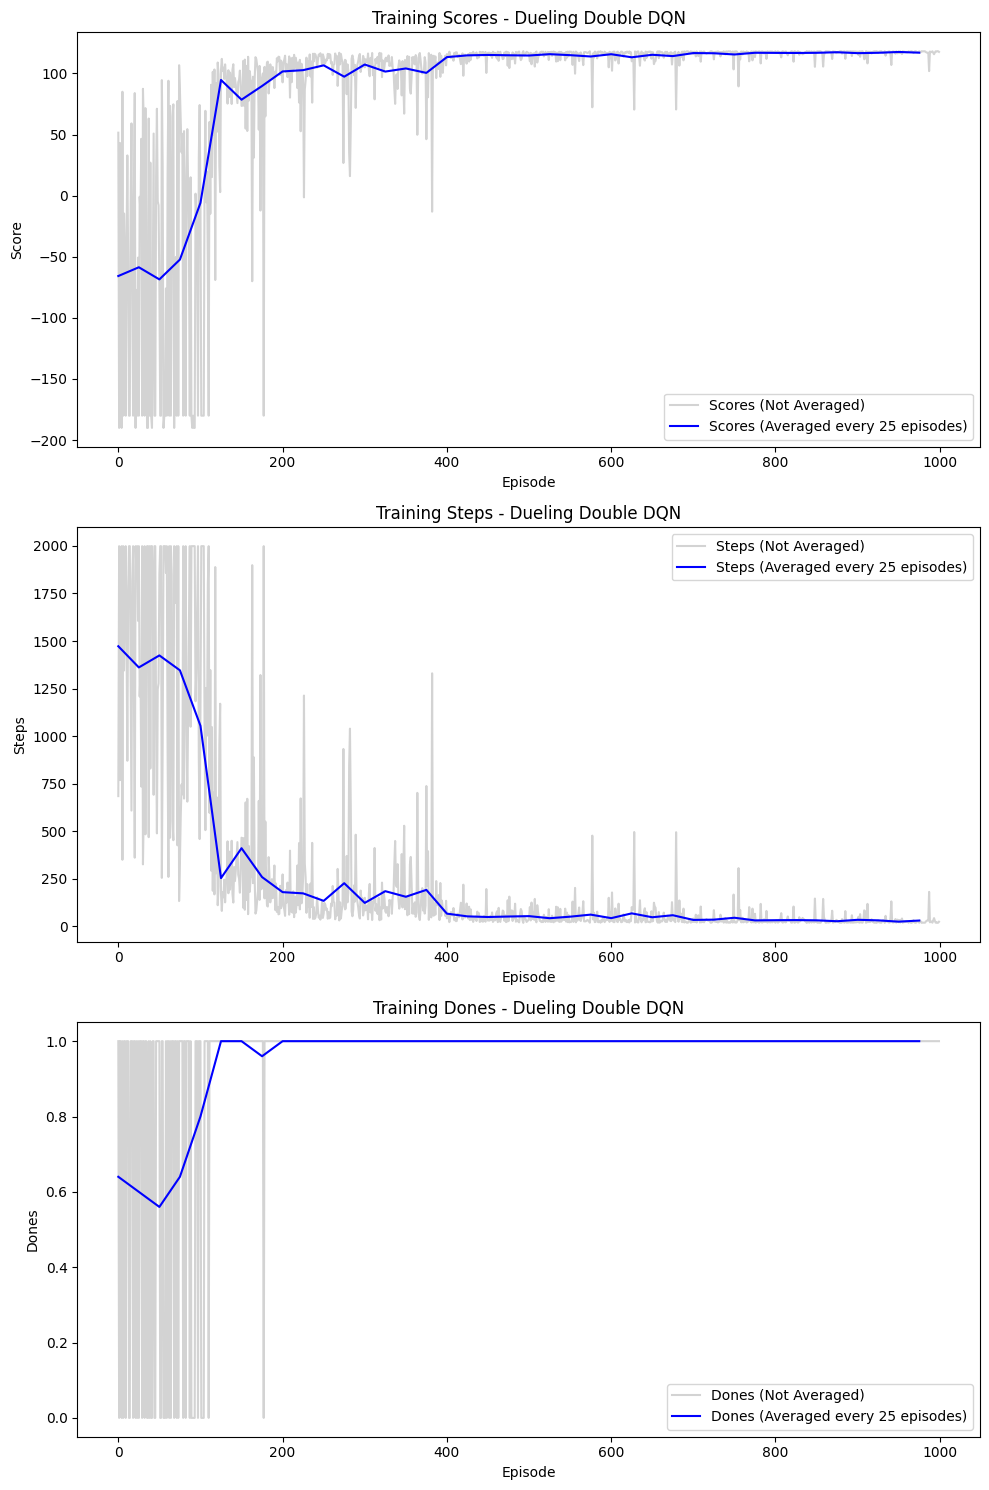

In [ ]:
# Load the model scores and steps
dueling_double_DQN_agent_key.load(path_for_agent)
scores_steps_dones = pd.read_csv(path_for_scores_steps)
print(f"Scores, steps, and dones loaded from DuelingDoubleDQN_scores_steps_{hyperparameters_str}.csv")

# Extract scores, steps, and dones
dueling_double_dqn_scores_key = scores_steps_dones["scores"].values
dueling_double_dqn_steps_key = scores_steps_dones["steps"].values
dueling_double_dqn_dones_key = scores_steps_dones["dones"].values

# Parameters for averaging
avg_every = 25

# Plot the training performance
plot_training_performance(dueling_double_dqn_scores_key, dueling_double_dqn_steps_key, dueling_double_dqn_dones_key, avg_every=avg_every, algo_name="Dueling Double DQN", figsize=(10, 15))



- Evaluate the Agent

In [ ]:
# Evaluate the agent
print("Evaluating the Dueling Double DQN agent")
dueling_double_dqn_scores_eval_key, dueling_double_dqn_steps_eval_key, dueling_double_dqn_dones_eval_key = dueling_double_DQN_agent_key.evaluate(env=env, n_episodes=50)
print(f"Dueling Double DQN agent's average score: {dueling_double_dqn_scores_eval_key:.2f} -- average steps: {dueling_double_dqn_steps_eval_key:.2f} -- average dones: {dueling_double_dqn_dones_eval_key:.2f}")


Evaluating the Dueling Double DQN agent


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]

Dueling Double DQN agent's average score: 91.68 -- average steps: 138.24 -- average dones: 0.88


- Watch the Agent play

In [ ]:
video_filename = '/content/vid.mp4'
total_reward, step, done = save_video(dueling_double_DQN_agent_key, env, video_filename, max_steps=1000)
print(f"Total reward: {total_reward} -- Steps: {step} -- Done: {done}")
embed_mp4(video_filename)

Total reward: 118.1 -- Steps: 19 -- Done: True


### Comparison of the 4 agents on the Key Env

Comparing the agents training performance


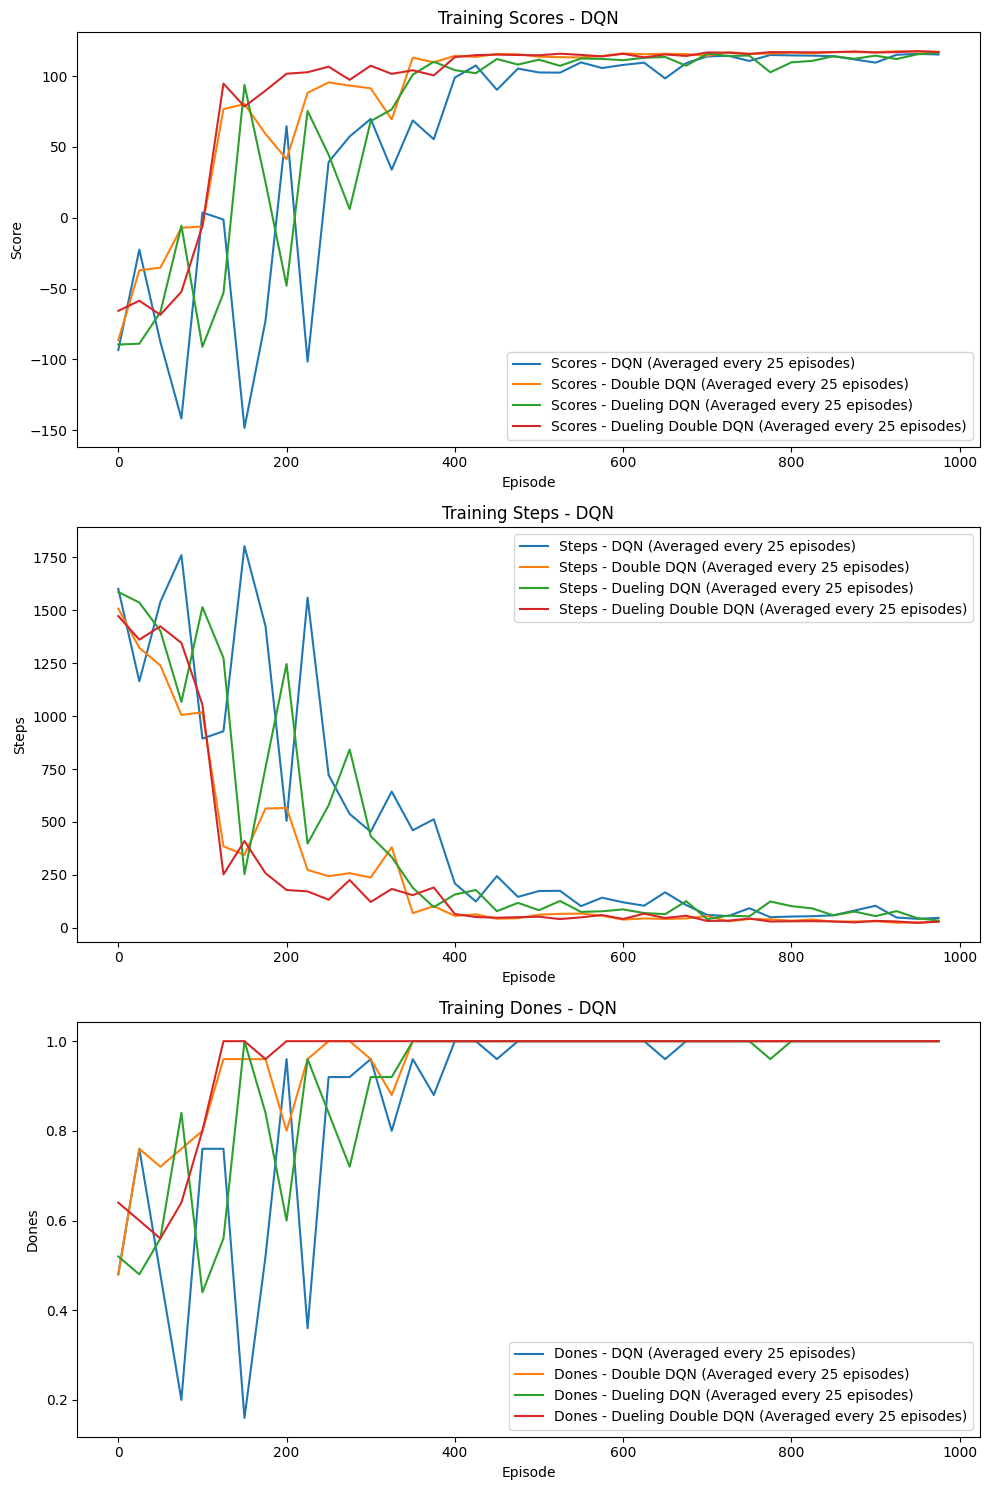

Comparing the agents evaluation performance


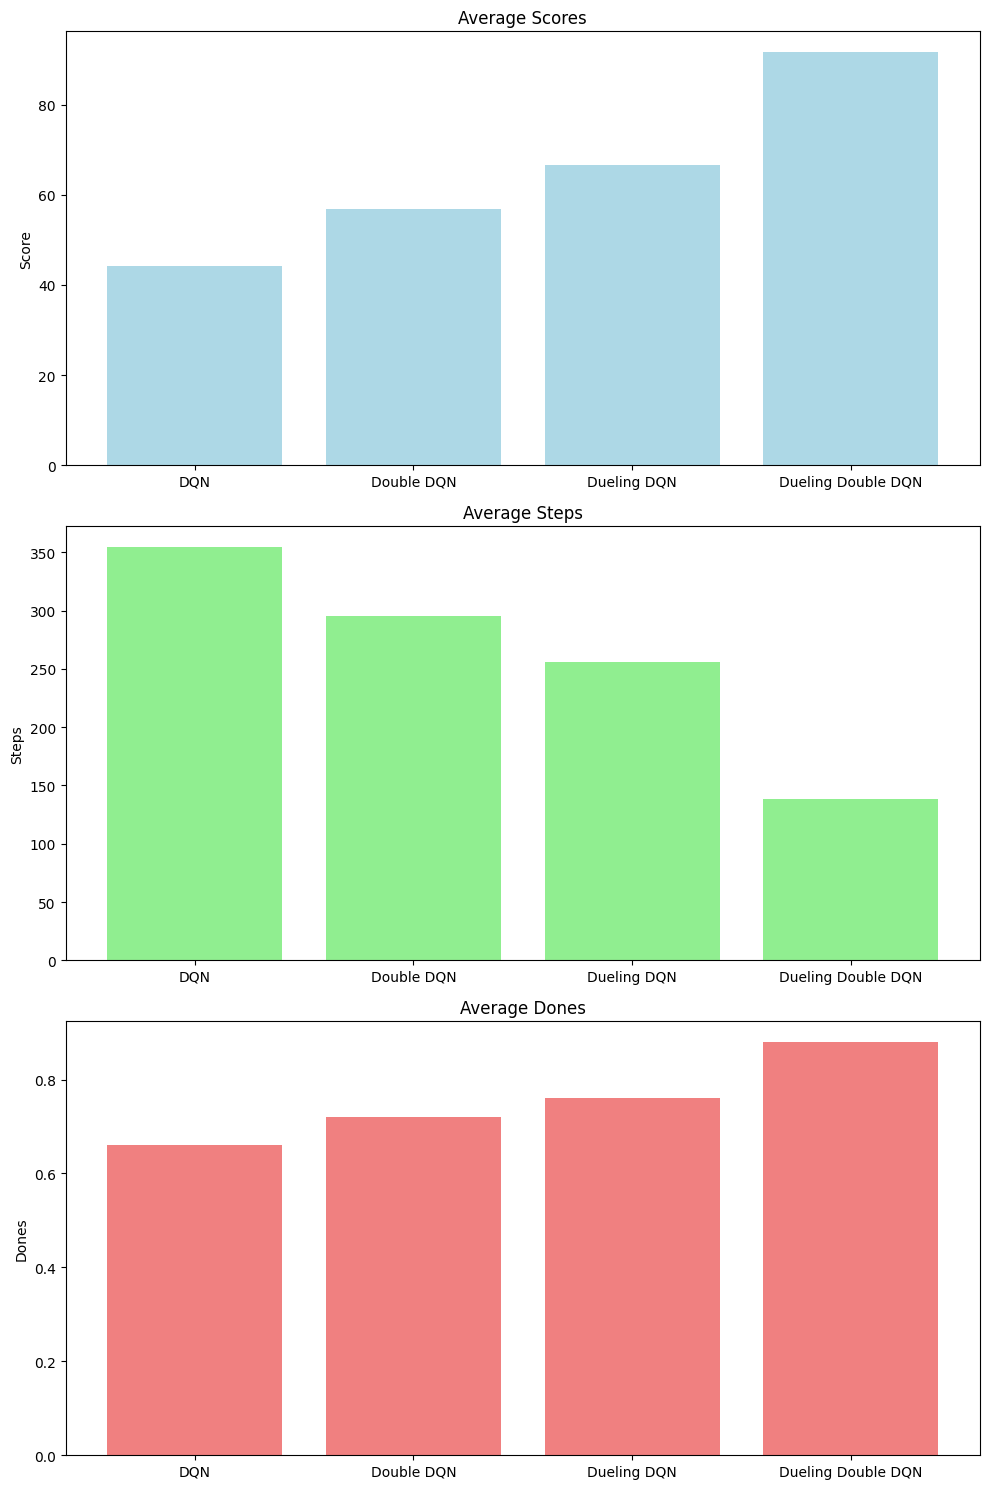

In [ ]:
# Compare the agents training performance
avg_every = 25
print("Comparing the agents training performance")
plot_training_performance_multi(
    scores_list=[dqn_scores_key, double_dqn_scores_key, dueling_dqn_scores_key, dueling_double_dqn_scores_key],
    steps_list=[dqn_steps_key, double_dqn_steps_key, dueling_dqn_steps_key, dueling_double_dqn_steps_key],
    dones_list=[dqn_dones_key, double_dqn_dones_key, dueling_dqn_dones_key, dueling_double_dqn_dones_key],
    labels=["DQN", "Double DQN", "Dueling DQN", "Dueling Double DQN"],
    avg_every=avg_every,
    figsize=(10, 15)
)

# Compare the agents evaluation performance
print("Comparing the agents evaluation performance")
plot_evaluation_performance_multi(
    scores_list=[dqn_scores_eval_key, double_dqn_scores_eval_key, dueling_dqn_scores_eval_key, dueling_double_dqn_scores_eval_key],
    steps_list=[dqn_steps_eval_key, double_dqn_steps_eval_key, dueling_dqn_steps_eval_key, dueling_double_dqn_steps_eval_key],
    dones_list=[dqn_dones_eval_key, double_dqn_dones_eval_key, dueling_dqn_dones_eval_key, dueling_double_dqn_dones_eval_key],
    labels=["DQN", "Double DQN", "Dueling DQN", "Dueling Double DQN"],
    figsize=(10, 15)
)

